The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
Four &quot;Corgie&quot; model vehicles were used for the experiment: a double decker bus, Cheverolet
van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
 
 
The points distribution for this case is as follows:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers
2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why
3. Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance)
4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy.

__N.B__ Question#4 has been removed from this list as SVM is not covered yet.

https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Common Functions -- START

In [2]:
def get_high_corrleation_features(df, field, threshold):
    THRESHOLD = threshold
    s = df.corr().loc[field]
    return pd.DataFrame(s[np.abs(s) > THRESHOLD].sort_values(ascending=False)).iloc[1:]

In [3]:
def highlight_odd(record, kwargs):
    """
    Takes a record and returns an array of same size as record with each value in array indicating 'background-color' 
    for each column. The 'background-color' is marked as red when the given cell is found to be violating some condition.
    Pls see the code to understand the condition being checked.
    This method requires following additional parameters to be passed through kwargs:
    1. OUTLIER_LIST - A list containing index of outlier records
    2. CATEGORY - A Category like Van, Car or Bus
    3. PERCENTAGE - Percentage value like 5 or 10 indicating the cutoff percentage applied while detecting odd cells.
    """
    
    outlier_records = kwargs['OUTLIER_LIST']
    category = kwargs['CATEGORY']
    percentage = kwargs['PERCENTAGE']
    
    output = ['' for i in range(len(record))]
    
    perc_val = (record[category]['Mean'] * percentage)/100
    i = 0
    for index in outlier_records:
        if ( (record['Outlier'][index] > (record[category]['Mean'] + perc_val)) | (record['Outlier'][index] < (record[category]['Mean'] - perc_val)) ):
            output[i] = 'background-color: red'
        i += 1

    return output

In [4]:
def draw_distplot(field):
    plt.figure(figsize=(13,8))
    ax=sns.distplot(car[field],            hist=False , label='vehicle=car', color='b')
    ax=sns.distplot(bus[field],            hist=False,  label='vehicle=bus', color='r')
    ax=sns.distplot(van[field],            hist=False,  label='vehicle=van', color='g')
    ax=sns.distplot(vehicles[field],       hist=False , label='all',         color='y')
    ax.axvline(car[field].mean(),   color='b', linestyle='--', label='Mean:car')
    ax.axvline(car[field].median(), color='b', linestyle='-',  label='Median:car')
    ax.axvline(bus[field].mean(),   color='r', linestyle='--', label='Mean:bus')
    ax.axvline(bus[field].median(), color='r', linestyle='-',  label='Median:bus')
    ax.axvline(van[field].mean(),   color='g', linestyle='--', label='Mean:van')
    ax.axvline(van[field].median(), color='g', linestyle='-',  label='Median:van')
    ax.axvline(vehicles[field].mean(),   color='y', linestyle='--', label='Mean:all')
    ax.axvline(vehicles[field].median(), color='y', linestyle='-',  label='Median:all')
    plt.legend(loc="upper right")

In [5]:
def draw_boxplot(field):
    sns.boxplot('class', field, data=vehicles, order=['car', 'bus', 'van'])

In [6]:
def print_skew(field):
    print("Car = {}, Bus = {}, Van = {}".format(car[field].skew(), bus[field].skew(), van[field].skew()))

In [7]:
def print_kurt(field):
    print("Car = {}, Bus = {}, Van = {}".format(car[field].kurt(), bus[field].kurt(), van[field].kurt()))

In [8]:
def grab_outliers(dataset, field):
    z = stats.zscore(dataset[field])
    return dataset[z > 3]    

In [9]:
def grab_outliers_IQR(dataset, field):
    _, lower, upper = get_IQR(dataset, field)
    return dataset[(dataset[field] < lower) | (dataset[field] > upper)]

In [10]:
def highlight_other_features(outliers, category_df, category_label):
    d = {}

    # Add outliers dataframe to dictionary
    outliers = outliers.drop('class', axis=1, errors='ignore')
    d['Outlier'] = outliers.T

    # Prepare Reference dataframe & add to dictionary
    f1 = pd.DataFrame(category_df.mean(), columns=["Mean"])
    d[category_label] = f1

    # Consolidate both dataframes added to dictionary to create two level Index for columns (e.g. Van -> Mean)
    consolidated = pd.concat(d, axis=1, sort=False)
    
    other_parms = {}
    other_parms['CATEGORY'] = category_label
    other_parms['OUTLIER_LIST'] = outliers.index.tolist()
    other_parms['PERCENTAGE'] = CUT_OFF_PERCENTAGE
    return consolidated.style.apply(highlight_odd, axis=1, kwargs=other_parms)

In [11]:
def refresh_datasets(vehicles):
    """
    Returns car, bus, van datasets in same order after refresh from main vehicles dataset
    """
    car = vehicles[vehicles['class'] == 'car']
    bus = vehicles[vehicles['class'] == 'bus']
    van = vehicles[vehicles['class'] == 'van']
    return car, bus, van

In [12]:
def get_IQR(dataset, field):
    """
    Calculates and returns IQR, Lower Whisker and Upper Whisker
    """
    Q1 = np.quantile(dataset[field], 0.25)
    Q3 = np.quantile(dataset[field], 0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return IQR, lower, upper

In [13]:
def color_as_positive(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: blue'` when the value is greater
    then some threshold value
    """
    color = 'blue' if np.abs(val) > THRESHOLD_CORR else 'black'
    return 'color: %s' % color

## Common Functions -- END

## Global Variables -- START

In [14]:
THRESHOLD_CORR = 0.4

In [15]:
CUT_OFF_PERCENTAGE = 10

## Global Variables -- END

In [16]:
vehicles = pd.read_csv("vehicle.csv")
vehicles.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

# [A] Clean Data, Transform Data, Visualization of Data

In [17]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

So we have 19 columns and 846 rows. Some of the columns have a few missing values; account for which is given below:
01. circularity - 5 missing values
02. distance_circularity - 4 missing values
03. radius_ratio - 6 missing values
04. pr.axis_aspect_ratio - 2 missing values
05. scatter_ratio - 1 missing value
06. elongatedness - 1 missing value
07. pr.axis_rectangularity - 3 missing values
08. scaled_variance - 3 missing values
09. scaled_variance.1 - 2 missing values
10. scaled_radius_of_gyration - 2 missing values
11. scaled_radius_of_gyration.1 - 4 missing value
12. skewness_about - 6 missing values
13. skewness_about.1 - 1 missing value
14. skewness_about.2 - 1 missing value

In [18]:
#type(pplot)

In [19]:
vehicles['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [20]:
#vehicles['class'] = vehicles['class'].map(lambda x :  1 if x == 'car' else (2 if x == 'bus' else 3))
#vehicles['class'].value_counts()

In [21]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

In [22]:
vehicles.pivot_table(index='class', aggfunc=['mean', 'median']).T

class                                      bus         car         van
mean   circularity                   44.981308   46.035047   42.070352
       compactness                   91.591743   96.184149   90.562814
       distance_circularity          76.767442   88.878788   73.247475
       elongatedness                 40.114679   38.093458   47.939698
       hollows_ratio                191.325688  197.582751  196.145729
       max.length_aspect_ratio        7.013761    8.825175    9.713568
       max.length_rectangularity    146.701835  149.967366  145.175879
       pr.axis_aspect_ratio          63.414747   60.992991   61.261307
       pr.axis_rectangularity        20.580645   21.511682   18.575758
       radius_ratio                 165.708333  180.591549  147.176768
       scaled_radius_of_gyration    181.032407  179.613054  157.276382
       scaled_radius_of_gyration.1   77.096774   69.924883   72.778894
       scaled_variance              192.889908  197.894614  163.964646
       scaled_variance.1            448.894495  500.543326  298.201005
       scatter_ratio                170.022936  181.053738  141.537688
       skewness_about                 4.794393    7.126464    6.417085
       skewness_about.1              10.211009   15.170561    9.698492
       skewness_about.2             187.811927  189.474299  188.939698
median circularity                   44.000000   46.000000   42.000000
       compactness                   89.000000   97.000000   90.000000
       distance_circularity          72.000000   94.000000   75.000000
       elongatedness                 44.000000   36.000000   47.000000
       hollows_ratio                189.000000  198.000000  196.000000
       max.length_aspect_ratio        6.000000    9.000000    9.000000
       max.length_rectangularity    145.000000  150.000000  145.000000
       pr.axis_aspect_ratio          64.000000   61.000000   59.000000
       pr.axis_rectangularity        19.000000   22.000000   18.000000
       radius_ratio                 167.500000  186.000000  144.000000
       scaled_radius_of_gyration    176.000000  182.000000  159.000000
       scaled_radius_of_gyration.1   76.000000   70.000000   72.000000
       scaled_variance              177.000000  206.000000  164.000000
       scaled_variance.1            344.000000  512.000000  300.000000
       scatter_ratio                152.000000  185.000000  142.000000
       skewness_about                 5.000000    6.000000    6.000000
       skewness_about.1              10.000000   14.000000    9.000000
       skewness_about.2             186.000000  189.000000  188.000000

## [1] compactness
1. Variable type: int64, continuous
2. 0 missing values
3. (average perim)**2/area

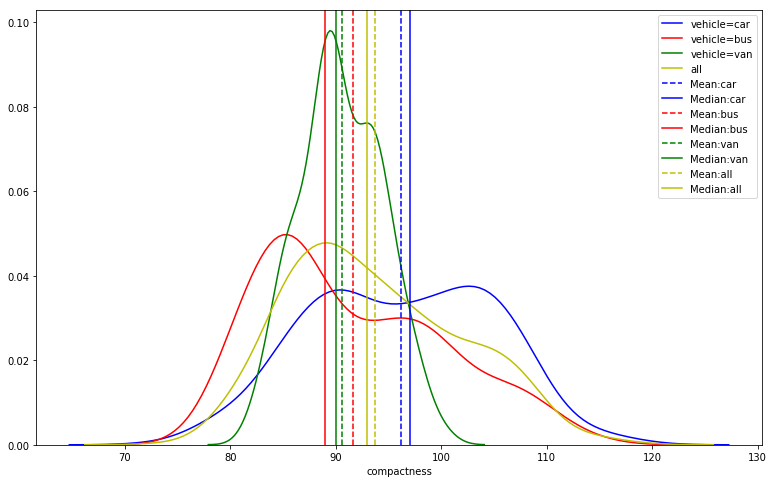

In [23]:
# Let's draw the plots
draw_distplot("compactness")

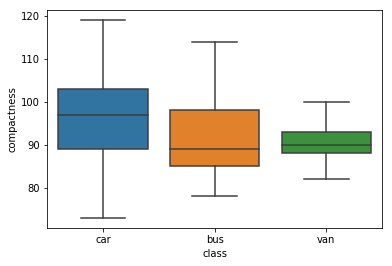

In [24]:
draw_boxplot("compactness")

In [25]:
print_skew("compactness")

Car = -0.05849050129296976, Bus = 0.5794020296284763, Van = 0.0776365608083228


In [26]:
print_kurt("compactness")

Car = -0.7158829539092375, Bus = -0.6668636424560348, Van = -0.585706415160979


1. Median compactness of van is slightly higher than bus but quite lower than car.
2. Most of the vans have very narrow range of compactness. Cars and Buses have wider range of compactness.
3. Buses have wide range of compactness in quartile 3. Infact, the upper whisker is also pretty stretched as compared lower. Buses have got right skewed distribution.
4. Cars have highest compactness and range of compactness is even too high. Both upper and lower whiskers are pretty stretched.
5. Cars have bimodal distribution with clearly two peaks visible. So in terms of compactness there should be two subgroups in cars category.
6. None of these 3 categories have got any outliers.

In [27]:
# Let's see which features are highly correlated with compactness. To do this, I am going to choose the features 
# having correlation value greater than THRESHOLD_CORR with compactness feature. 
get_high_corrleation_features(vehicles, 'compactness', THRESHOLD_CORR)
# Wov 10 other features are correlated

compactness
scaled_variance.1             0.818674
pr.axis_rectangularity        0.814248
scatter_ratio                 0.812770
distance_circularity          0.791707
scaled_variance               0.764361
radius_ratio                  0.691081
circularity                   0.689786
max.length_rectangularity     0.676143
scaled_radius_of_gyration     0.585845
elongatedness                -0.788736

## [2] circularity
1. Variable type: float64, continuous
2. 5 missing values
3. (average radius)**2/area

In [28]:
# Let's first locate the records with missing values
vehicles[vehicles['circularity'].isna()]
# 4 records [Index = 5, 118, 266 & 396] are for bus & 1 record [Index = 105] is for car

compactness  circularity  distance_circularity  radius_ratio  \
5            107          NaN                 106.0         172.0   
105          108          NaN                 103.0         202.0   
118           85          NaN                   NaN         128.0   
266           86          NaN                  65.0         116.0   
396          108          NaN                 106.0         177.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                        6          255.0   
105                  64.0                       10          220.0   
118                  56.0                        8          150.0   
266                  53.0                        6          152.0   
396                  51.0                        5          256.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    28.0                        169   
105           30.0                    25.0                        168   
118           46.0                    19.0                        144   
266           45.0                    19.0                        141   
396           26.0                    28.0                        170   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
5              280.0              957.0                      264.0   
105              NaN              711.0                      214.0   
118            168.0              324.0                      173.0   
266            175.0              335.0                        NaN   
396            285.0              966.0                      261.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
5                           85.0             5.0               9.0   
105                         73.0            11.0               NaN   
118                         82.0             9.0              14.0   
266                         85.0             5.0               4.0   
396                         87.0            11.0               2.0   

     skewness_about.2  hollows_ratio class  
5               181.0            183   bus  
105             188.0            199   car  
118             180.0            184   bus  
266             179.0            183   bus  
396             182.0            181   bus

In [29]:
# So let's impute them with the mean values of their respective category
vehicles.loc[[5, 118, 266, 396], 'circularity'] = bus['circularity'].mean()
vehicles.loc[[105], 'circularity'] = car['circularity'].mean()

In [30]:
# Let's validate if they are all imputed properly
vehicles.loc[[5, 105, 118, 266, 396]]

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308                 106.0         172.0   
105          108    46.035047                 103.0         202.0   
118           85    44.981308                   NaN         128.0   
266           86    44.981308                  65.0         116.0   
396          108    44.981308                 106.0         177.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                        6          255.0   
105                  64.0                       10          220.0   
118                  56.0                        8          150.0   
266                  53.0                        6          152.0   
396                  51.0                        5          256.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    28.0                        169   
105           30.0                    25.0                        168   
118           46.0                    19.0                        144   
266           45.0                    19.0                        141   
396           26.0                    28.0                        170   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
5              280.0              957.0                      264.0   
105              NaN              711.0                      214.0   
118            168.0              324.0                      173.0   
266            175.0              335.0                        NaN   
396            285.0              966.0                      261.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
5                           85.0             5.0               9.0   
105                         73.0            11.0               NaN   
118                         82.0             9.0              14.0   
266                         85.0             5.0               4.0   
396                         87.0            11.0               2.0   

     skewness_about.2  hollows_ratio class  
5               181.0            183   bus  
105             188.0            199   car  
118             180.0            184   bus  
266             179.0            183   bus  
396             182.0            181   bus

## ----------------- EXTRA: example to understand interpolation ------ START

In [31]:
# Simple example to understand interpolation
df = pd.DataFrame({"A":[12, 4, 5, None, 1], 
                   "B":[None, 2, 54, 3, None], 
                   "C":[20, 16, None, 3, 8], 
                   "D":[14, 3, None, None, 6]})
df

A     B     C     D
0  12.0   NaN  20.0  14.0
1   4.0   2.0  16.0   3.0
2   5.0  54.0   NaN   NaN
3   NaN   3.0   3.0   NaN
4   1.0   NaN   8.0   6.0

In [32]:
df.interpolate(method ='linear', limit_direction ='forward')
# Observe 
# 0B isn't filled
# 2C filled with average of 1C & 3C
# 2D & 3D filled in intelligently in a way that 2D is average of 1D & 3D; 3D is average of 2D & 4D. Chicken and hen kind of 
# situation though.
# 3A filled with average of 2A & 4A
# 4B filled in with value of 3B

A     B     C     D
0  12.0   NaN  20.0  14.0
1   4.0   2.0  16.0   3.0
2   5.0  54.0   9.5   4.0
3   3.0   3.0   3.0   5.0
4   1.0   3.0   8.0   6.0

In [33]:
df.interpolate(method ='linear', limit_direction ='backward') 

A     B     C     D
0  12.0   2.0  20.0  14.0
1   4.0   2.0  16.0   3.0
2   5.0  54.0   9.5   4.0
3   3.0   3.0   3.0   5.0
4   1.0   NaN   8.0   6.0

In [34]:
df.interpolate(method ='nearest')

A     B     C     D
0  12.0   NaN  20.0  14.0
1   4.0   2.0  16.0   3.0
2   5.0  54.0  16.0   3.0
3   5.0   3.0   3.0   6.0
4   1.0   NaN   8.0   6.0

## ----------------- EXTRA: example to understand interpolation ------ END

In [35]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

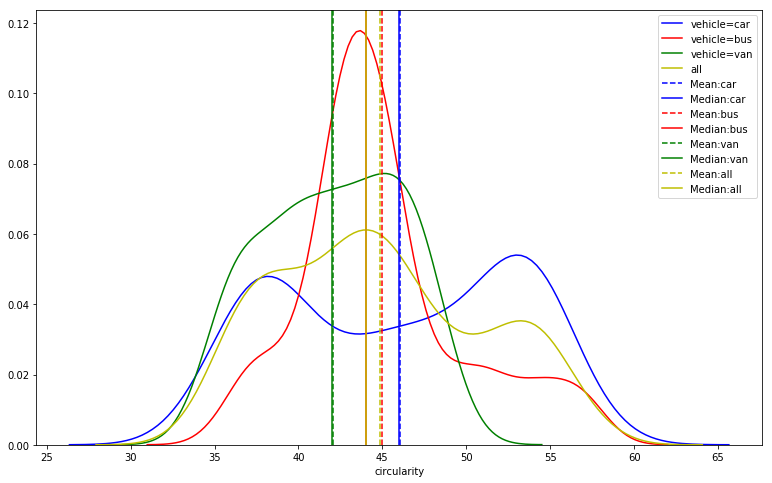

In [36]:
# Let's draw the plots
draw_distplot("circularity")

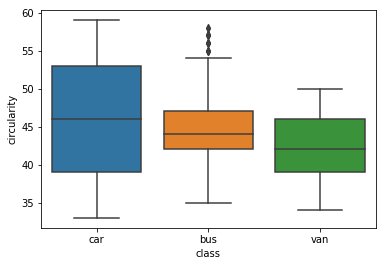

In [37]:
draw_boxplot("circularity")

In [38]:
print_skew("circularity")

Car = -0.10094782235190104, Bus = 0.772532846857724, Van = -0.12042060392646031


In [39]:
print_kurt("circularity")

Car = -1.4046123669787574, Bus = 0.4067972870820862, Van = -1.0904626704567468


1. Cars have pretty wide range of circularity. Also, circularity has bimodal distribution for cars.
2. circularity for buses is right skewed with heavy tail too. Q1 & Q4 have higher range than other quartiles.
3. Vans have lower range of circularity. Q1 has higher range than other quartiles.

In [40]:
# There are a few outliers for bus category. Using z-scores, let's see who all are outliers
outliers = grab_outliers_IQR(bus, "circularity")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
54           101         56.0                 104.0         185.0   
85           110         58.0                 106.0         180.0   
155          110         56.0                 103.0         223.0   
193          107         55.0                  98.0         199.0   
274          107         57.0                 106.0         179.0   
294          109         55.0                 102.0         169.0   
321          113         57.0                 109.0         194.0   
334          107         57.0                 102.0         184.0   
531          107         55.0                 103.0         167.0   
539          109         55.0                  96.0         191.0   
556          108         56.0                 102.0         246.0   
683          110         56.0                 109.0         199.0   
687          106         57.0                 107.0         235.0   
733          114         57.0                 102.0         181.0   
835          111         58.0                 105.0         183.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
54                   53.0                        6          257.0   
85                   51.0                        6          261.0   
155                  64.0                        5          250.0   
193                  59.0                        7          240.0   
274                  51.0                        8          257.0   
294                  51.0                        6          241.0   
321                  56.0                        6          260.0   
334                  55.0                        7          234.0   
531                  49.0                        7          252.0   
539                  57.0                        6          241.0   
556                  75.0                        6          239.0   
683                  57.0                        5          251.0   
687                  67.0                        6          262.0   
733                  52.0                        6          257.0   
835                  51.0                        6          265.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
54            26.0                    28.0                        168   
85            26.0                    28.0                        171   
155           26.0                    27.0                        169   
193           27.0                    26.0                        168   
274           26.0                    28.0                        172   
294           27.0                    26.0                        165   
321           26.0                    28.0                        175   
334           28.0                    26.0                        171   
531           27.0                    28.0                        172   
539           28.0                    26.0                        170   
556           28.0                    26.0                        167   
683           27.0                    27.0                        169   
687           26.0                    28.0                        171   
733           26.0                    28.0                        169   
835           26.0                    29.0                        174   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
54             275.0              956.0                      230.0   
85             278.0              998.0                      257.0   
155            280.0              928.0                      239.0   
193            258.0              866.0                      245.0   
274            275.0              954.0                      232.0   
294            265.0              870.0                      247.0   
321            288.0              982.0                      261.0   
334            243.0              822.0                      229.0

In [41]:
# Let's replace these outlier with upper whisker
_, lower, upper = get_IQR(bus, 'circularity')
vehicles.loc[outliers.index.tolist(), 'circularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [42]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "circularity")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [43]:
# Let's see which features are highly correlated with circularity. 
get_high_corrleation_features(vehicles, 'circularity', THRESHOLD_CORR)
# Wov 10 other features are correlated

circularity
max.length_rectangularity     0.963044
scaled_radius_of_gyration     0.924130
scatter_ratio                 0.844539
pr.axis_rectangularity        0.840398
scaled_variance.1             0.833465
distance_circularity          0.793848
scaled_variance               0.790745
compactness                   0.682360
radius_ratio                  0.625217
elongatedness                -0.820637

## [3] distance_circularity
1. Variable type: float64, continuous
2. 4 missing values
3. area/(av.distance from border)**2

In [44]:
# Let's first locate the records with missing values
vehicles[vehicles['distance_circularity'].isna()]
# 3 records [Index = 118, 207, 319] are for bus & 1 record [Index = 35] is for van

compactness  circularity  distance_circularity  radius_ratio  \
35           100    46.000000                   NaN         172.0   
118           85    44.981308                   NaN         128.0   
207           85    42.000000                   NaN         121.0   
319          102    51.000000                   NaN         194.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
35                   67.0                        9          157.0   
118                  56.0                        8          150.0   
207                  55.0                        7          149.0   
319                  60.0                        6          220.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
35            43.0                    20.0                        150   
118           46.0                    19.0                        144   
207           46.0                    19.0                        146   
319           30.0                    25.0                        162   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
35             170.0              363.0                      184.0   
118            168.0              324.0                      173.0   
207            167.0              323.0                        NaN   
319            247.0              731.0                      209.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
35                          67.0            17.0               7.0   
118                         82.0             9.0              14.0   
207                         85.0             1.0               6.0   
319                         80.0             7.0               7.0   

     skewness_about.2  hollows_ratio class  
35              192.0            200   van  
118             180.0            184   bus  
207             179.0            182   bus  
319             188.0            186   bus

In [45]:
# So let's impute them with the mean values of their respective category
vehicles.loc[[118, 207, 319], 'distance_circularity'] = bus['distance_circularity'].mean()
vehicles.loc[[35], 'distance_circularity'] = van['distance_circularity'].mean()

In [46]:
# Let's validate if they are correctly imputed now
vehicles.loc[[35, 118, 207, 319]]

compactness  circularity  distance_circularity  radius_ratio  \
35           100    46.000000             73.247475         172.0   
118           85    44.981308             76.767442         128.0   
207           85    42.000000             76.767442         121.0   
319          102    51.000000             76.767442         194.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
35                   67.0                        9          157.0   
118                  56.0                        8          150.0   
207                  55.0                        7          149.0   
319                  60.0                        6          220.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
35            43.0                    20.0                        150   
118           46.0                    19.0                        144   
207           46.0                    19.0                        146   
319           30.0                    25.0                        162   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
35             170.0              363.0                      184.0   
118            168.0              324.0                      173.0   
207            167.0              323.0                        NaN   
319            247.0              731.0                      209.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
35                          67.0            17.0               7.0   
118                         82.0             9.0              14.0   
207                         85.0             1.0               6.0   
319                         80.0             7.0               7.0   

     skewness_about.2  hollows_ratio class  
35              192.0            200   van  
118             180.0            184   bus  
207             179.0            182   bus  
319             188.0            186   bus

In [47]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

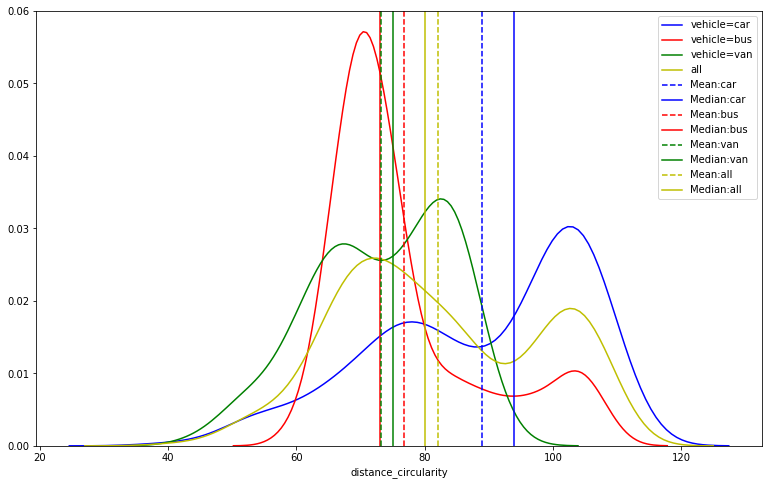

In [48]:
# Let's draw the plots
draw_distplot("distance_circularity")

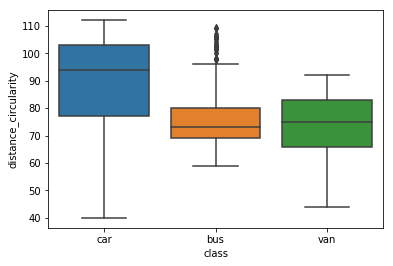

In [49]:
draw_boxplot("distance_circularity")

In [50]:
print_skew("distance_circularity")

Car = -0.632725238658727, Bus = 1.248009072213965, Van = -0.40761381274193237


In [51]:
print_kurt("distance_circularity")

Car = -0.6151006388095426, Bus = 0.5242883661570961, Van = -0.710921762176127


In [52]:
outliers = grab_outliers_IQR(bus, "distance_circularity")
outliers
# So got quite many outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308                 106.0         172.0   
54           101    54.500000                 104.0         185.0   
85           110    54.500000                 106.0         180.0   
155          110    54.500000                 103.0         223.0   
171          106    54.000000                 103.0         161.0   
173           96    49.000000                  98.0         187.0   
193          107    54.500000                  98.0         199.0   
274          107    54.500000                 106.0         179.0   
294          109    54.500000                 102.0         169.0   
321          113    54.500000                 109.0         194.0   
334          107    54.500000                 102.0         184.0   
345          101    54.000000                 106.0           NaN   
381          106    54.000000                 100.0         227.0   
396          108    44.981308                 106.0         177.0   
444          102    53.000000                 101.0         238.0   
494          106    54.000000                 105.0         164.0   
531          107    54.500000                 103.0         167.0   
556          108    54.500000                 102.0         246.0   
683          110    54.500000                 109.0         199.0   
687          106    54.500000                 107.0         235.0   
710          102    54.000000                  98.0         201.0   
731          103    52.000000                 103.0         170.0   
733          114    54.500000                 102.0         181.0   
738          100    50.000000                  98.0         204.0   
777          106    53.000000                  98.0         154.0   
835          111    54.500000                 105.0         183.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                        6          255.0   
54                   53.0                        6          257.0   
85                   51.0                        6          261.0   
155                  64.0                        5          250.0   
171                  47.0                        4          247.0   
173                  59.0                        6          213.0   
193                  59.0                        7          240.0   
274                  51.0                        8          257.0   
294                  51.0                        6          241.0   
321                  56.0                        6          260.0   
334                  55.0                        7          234.0   
345                  57.0                        7          236.0   
381                  67.0                        4          250.0   
396                  51.0                        5          256.0   
444                  72.0                        4          238.0   
494                  48.0                        5          247.0   
531                  49.0                        7          252.0   
556                  75.0                        6          239.0   
683                  57.0                        5          251.0   
687                  67.0                        6          262.0   
710                  61.0                        6          225.0   
731                  52.0                        7          236.0   
733                  52.0                        6          257.0   
738                  63.0                        6          218.0   
777                  47.0                        4          237.0   
835                  51.0                        6          265.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    28.0                        169   
54            26.0                    28.0                        168   
85            26.0                    28.0                

In [53]:
# Let's replace outliers with upper whisker
_, lower, upper = get_IQR(bus, 'distance_circularity')
vehicles.loc[outliers.index.tolist(), 'distance_circularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [54]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "distance_circularity")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

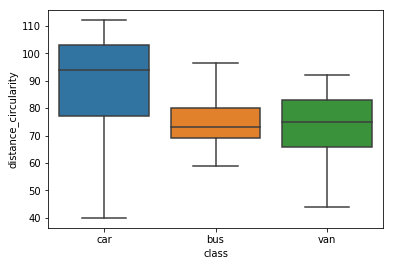

In [55]:
draw_boxplot("distance_circularity")

1. Pretty long Q1 (indicating strong left skew) for car and widest range as well. Again two peaks visible in dist plot.
2. Bus has a large peak on left and a small peak on right. Quite right skewed distribution.
3. Van has pretty wide Q1 (indicating strong left skew). Q2, Q3 & Q4 are of almost equal size.

In [56]:
# Let's see which features are highly correlated with circularity. 
get_high_corrleation_features(vehicles, 'distance_circularity', THRESHOLD_CORR)
# Wov 10 other features are correlated

distance_circularity
scatter_ratio                          0.887984
pr.axis_rectangularity                 0.874112
scaled_variance.1                      0.866571
scaled_variance                        0.841628
circularity                            0.787024
compactness                            0.780304
radius_ratio                           0.773823
max.length_rectangularity              0.767671
scaled_radius_of_gyration              0.686661
elongatedness                         -0.901742

## [4] radius_ratio
1. Variable type: float64, continuous
2. 6 missing values
3. (max.rad-min.rad)/av.radius

In [57]:
# Let's first locate the records with missing values
vehicles[vehicles['radius_ratio'].isna()][['radius_ratio', 'class']]
# 3 records [Index = 9, 159, 467] are for car, 2 records [Index = 78, 345] are for bus and 1 record [Index = 287] for van

radius_ratio class
9             NaN   car
78            NaN   bus
159           NaN   car
287           NaN   van
345           NaN   bus
467           NaN   car

In [58]:
# Let's impute them with the mean values for their corresponding class
vehicles.loc[[9, 159, 467], 'radius_ratio'] = car['radius_ratio'].mean()
vehicles.loc[[78, 345], 'radius_ratio'] = bus['radius_ratio'].mean()
vehicles.loc[[287], 'radius_ratio'] = van['radius_ratio'].mean()

In [59]:
vehicles.loc[[9, 159, 467, 78, 345, 287]][['radius_ratio', 'class']]

radius_ratio class
9      180.591549   car
159    180.591549   car
467    180.591549   car
78     165.708333   bus
345    165.708333   bus
287    147.176768   van

In [60]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

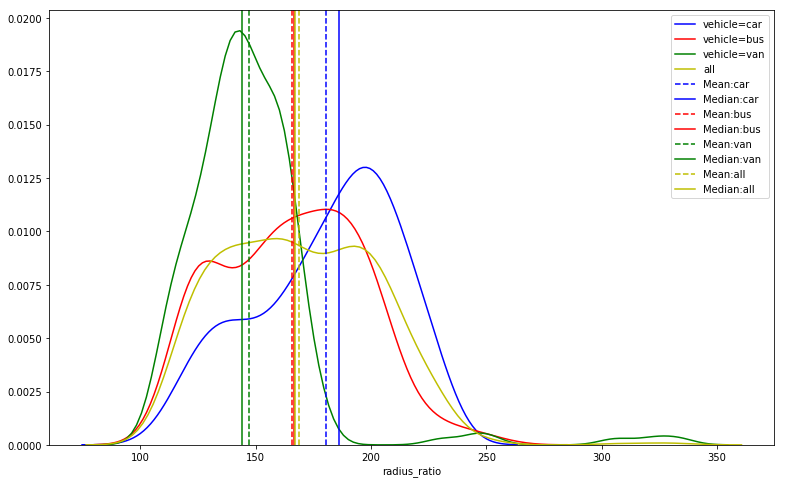

In [61]:
# Let's draw the plots
draw_distplot("radius_ratio")

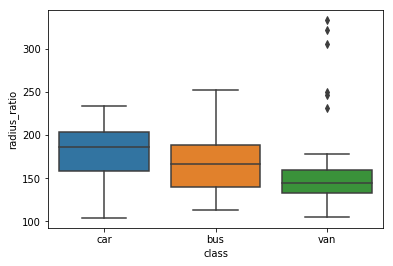

In [62]:
draw_boxplot("radius_ratio")

In [63]:
# So let's see what records are outliers
outliers = grab_outliers_IQR(van, "radius_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
37            90         48.0                  86.0         306.0   
135           89         47.0                  83.0         322.0   
291           89         45.0                  81.0         246.0   
388           94         47.0                  85.0         333.0   
523           90         43.0                  81.0         231.0   
706           82         43.0                  70.0         250.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
37                  126.0                       49          153.0   
135                 133.0                       48          158.0   
291                 102.0                       43          155.0   
388                 138.0                       49          155.0   
523                  97.0                       46          150.0   
706                 105.0                       55          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
37            44.0                    19.0                        156   
135           43.0                    20.0                        163   
291           44.0                    20.0                        160   
388           43.0                    19.0                        155   
523           45.0                    19.0                        149   
706           48.0                    18.0                        145   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
37             272.0              346.0                      200.0   
135            229.0              364.0                      176.0   
291            200.0              347.0                      177.0   
388            320.0              354.0                      187.0   
523            200.0              332.0                      164.0   
706            231.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
37                         118.0             0.0              15.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
523                         91.0             5.0               9.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
37              185.0            194   van  
135             184.0            194   van  
291             183.0            192   van  
388             188.0            196   van  
523             186.0            196   van  
706             190.0            199   van

In [64]:
# Let's see if only radius_ratio is an outlier or the other features of these outlier records are also too far away
# from the mean of corresponding features.
# Let's check if the other features of these outliers are in 10% range (+ or - 10%) of the mean value of those features.
# A cell of outlier record is highlighted with red if it's not in 10% range of the mean value of corresponding feature.
# Like below circularity of outlier record 37 has a value of 48. The mean for this feature in VAN Category is 42.0704. 
# 10% of this mean would be 4.20704. Circularity of outlier 37 (48) is not within 10% range 
# ( Lower = 37.86336 & Upper = 46.27744). Hence it's highlighted with red background.
# This way we can highlight the remaining features of outlier 37. Eventually we see that out of 18 features, 11 features for 
# outlier 37 have been highlighted.

consolidated = highlight_other_features(outliers, van, "Van")
consolidated

In [65]:
# So not just radius_ratio, but most of the other fields for these outliers are outside the 10% range of mean values in their category (VAN).
# Ideally, one should run these records through Domain Experts to understand if such high values are some type of error 
# OR they are genuine cases. If they are genunie cases they bring in good variance to the table. 
# Since we don't have access to Domain Experts, for now I would just transform these records using upper whisker.

In [66]:
_, lower, upper = get_IQR(van, 'radius_ratio')
vehicles.loc[outliers.index.tolist(), 'radius_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [67]:
outliers = grab_outliers_IQR(van, "radius_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [68]:
# It's advised by Great Lakes Support not to reprocess the new outliers
# so not doing anything for newly popped outlier 
# https://olympus1.greatlearning.in/program_support/requests/4933

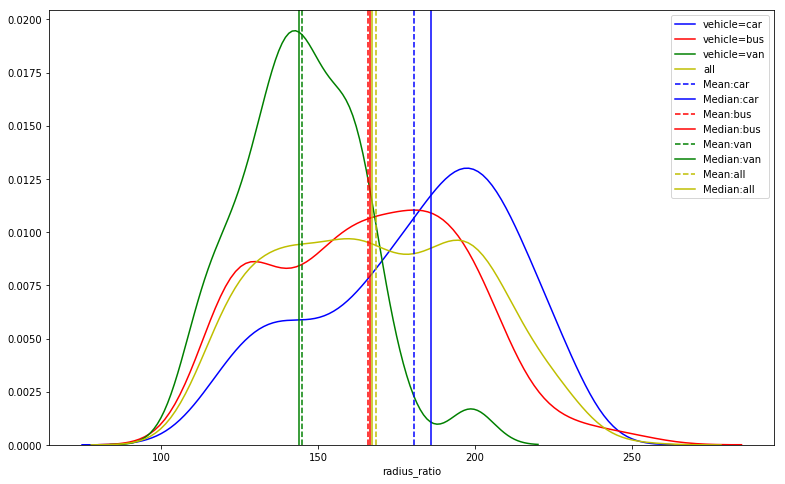

In [69]:
# Let's draw the plots
draw_distplot("radius_ratio")

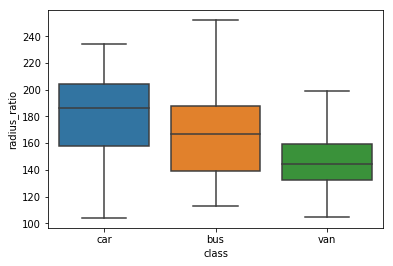

In [70]:
draw_boxplot("radius_ratio")

In [71]:
print_skew("radius_ratio")

Car = -0.44497286619721554, Bus = 0.14791541882288534, Van = 0.3637815923225437


In [72]:
print_kurt("radius_ratio")

Car = -0.7441484236670752, Bus = -0.6430776728748264, Van = 0.27902217736829993


In [73]:
# Let's see which features are highly correlated with compactness.  
get_high_corrleation_features(vehicles, 'radius_ratio', THRESHOLD_CORR)
# Wov 13 other features are correlated

radius_ratio
distance_circularity           0.806188
scaled_variance                0.789848
scatter_ratio                  0.777232
scaled_variance.1              0.764586
pr.axis_rectangularity         0.751115
compactness                    0.729583
circularity                    0.646882
max.length_rectangularity      0.584770
scaled_radius_of_gyration      0.557847
pr.axis_aspect_ratio           0.548111
hollows_ratio                  0.494806
skewness_about.2               0.409358
elongatedness                 -0.833137

1. radius_ratio distribution for cars is left skewed; Q1 is pretty stretched.
2. radius_ratio distribution for bus seems right skewed; Q4 is pretty stretched. It has got two peaks. Left is shorter though.
3. after transforming 5 records from Van category, radius_ratio distribution looks pretty normal. There is still skew though.
4. radius_ratio is having good correlation with many other features, which is good for dimensionality reduction.

## [5] pr.axis_aspect_ratio
1. Variable type: float64, continuous
2. 2 missing values
3. (minor axis)/(major axis)

In [74]:
# Let's first locate the records with missing values
vehicles[vehicles['pr.axis_aspect_ratio'].isna()][['pr.axis_aspect_ratio', 'class']]
# 1 record [Index = 19] are for car & 1 record [Index = 222] are for bus

pr.axis_aspect_ratio class
19                    NaN   car
222                   NaN   bus

In [75]:
# Let's impute them with the mean values for their corresponding class
vehicles.loc[[19], 'pr.axis_aspect_ratio'] = car['pr.axis_aspect_ratio'].mean()
vehicles.loc[[222], 'pr.axis_aspect_ratio'] = bus['pr.axis_aspect_ratio'].mean()

In [76]:
# Let's validate
vehicles.loc[[19, 222]][['pr.axis_aspect_ratio', 'class']]

pr.axis_aspect_ratio class
19              60.992991   car
222             63.414747   bus

In [77]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

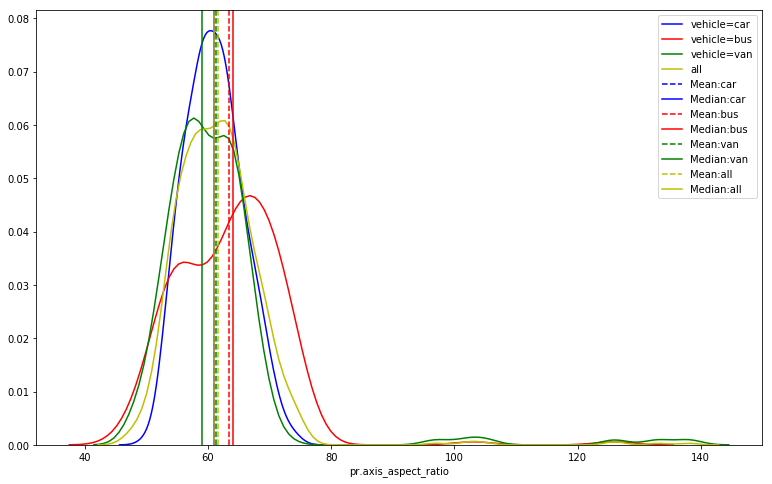

In [78]:
# Let's draw the plots
draw_distplot("pr.axis_aspect_ratio")

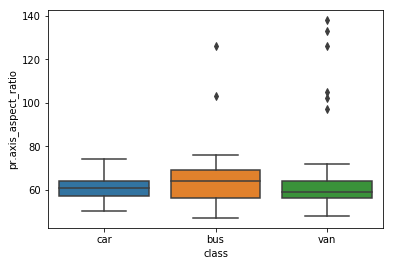

In [79]:
draw_boxplot("pr.axis_aspect_ratio")

In [80]:
print_skew("pr.axis_aspect_ratio")

Car = 0.25880171190188855, Bus = 1.8682433786195396, Van = 4.3645657005011715


In [81]:
print_kurt("pr.axis_aspect_ratio")

Car = -0.4288718074779845, Bus = 11.972165987615412, Van = 24.007144633060296


In [82]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, "pr.axis_aspect_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
4             85         44.0                  70.0         205.0   
100           82         45.0                  66.0         252.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
4                   103.0                       52          149.0   
100                 126.0                       52          148.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
4             45.0                    19.0                        144   
100           45.0                    19.0                        144   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
4              241.0              325.0                      188.0   
100            237.0              326.0                      185.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
4                          127.0             9.0              11.0   
100                        119.0             1.0               1.0   

     skewness_about.2  hollows_ratio class  
4               180.0            183   bus  
100             181.0            185   bus

In [83]:
# Let's assess these outliers. 
# Highlight other features that are 10% away from mean
consolidated = highlight_other_features(outliers, bus, "bus")
consolidated

In [84]:
# Let's replace them with upper whisker.
_, lower, upper = get_IQR(bus, 'pr.axis_aspect_ratio')
vehicles.loc[outliers.index.tolist(), 'pr.axis_aspect_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [85]:
# Let's check if any new outliers have popped up
outliers = grab_outliers_IQR(bus, "pr.axis_aspect_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [86]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, "pr.axis_aspect_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
37            90         48.0                  86.0        198.75   
135           89         47.0                  83.0        198.75   
291           89         45.0                  81.0        198.75   
388           94         47.0                  85.0        198.75   
523           90         43.0                  81.0        198.75   
706           82         43.0                  70.0        198.75   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
37                  126.0                       49          153.0   
135                 133.0                       48          158.0   
291                 102.0                       43          155.0   
388                 138.0                       49          155.0   
523                  97.0                       46          150.0   
706                 105.0                       55          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
37            44.0                    19.0                        156   
135           43.0                    20.0                        163   
291           44.0                    20.0                        160   
388           43.0                    19.0                        155   
523           45.0                    19.0                        149   
706           48.0                    18.0                        145   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
37             272.0              346.0                      200.0   
135            229.0              364.0                      176.0   
291            200.0              347.0                      177.0   
388            320.0              354.0                      187.0   
523            200.0              332.0                      164.0   
706            231.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
37                         118.0             0.0              15.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
523                         91.0             5.0               9.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
37              185.0            194   van  
135             184.0            194   van  
291             183.0            192   van  
388             188.0            196   van  
523             186.0            196   van  
706             190.0            199   van

In [87]:
# Let's replace them with upper whisker.
_, lower, upper = get_IQR(van, 'pr.axis_aspect_ratio')
vehicles.loc[outliers.index.tolist(), 'pr.axis_aspect_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [88]:
# Let's check if any new outliers have popped up
outliers = grab_outliers_IQR(van, "pr.axis_aspect_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

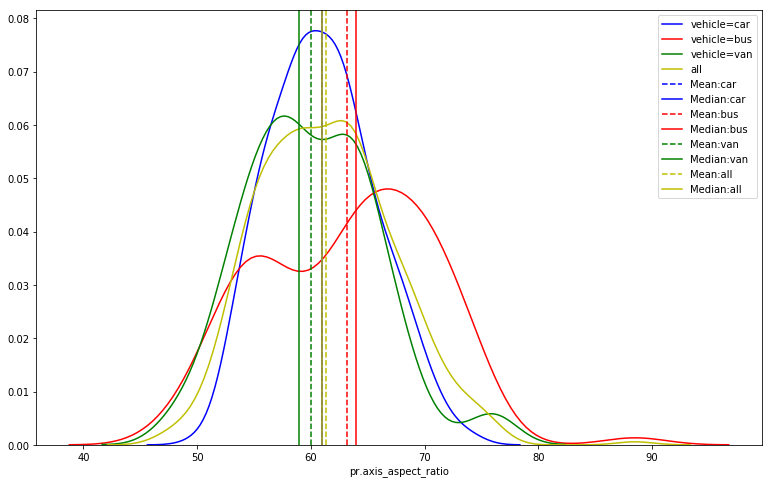

In [89]:
# Let's redraw the plots
draw_distplot("pr.axis_aspect_ratio")

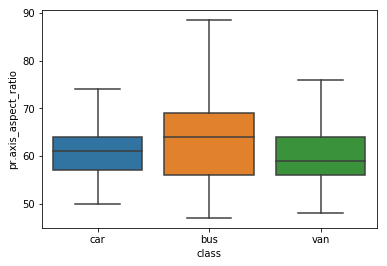

In [90]:
draw_boxplot("pr.axis_aspect_ratio")

In [91]:
get_high_corrleation_features(vehicles, "pr.axis_aspect_ratio", THRESHOLD_CORR)
# Only 1 feature is correlated

pr.axis_aspect_ratio
radius_ratio              0.661141

## [6] max.length_aspect_ratio
1. Variable type: int64, continuous
2. 0 missing values
3. (length perp. max length)/(max length) 

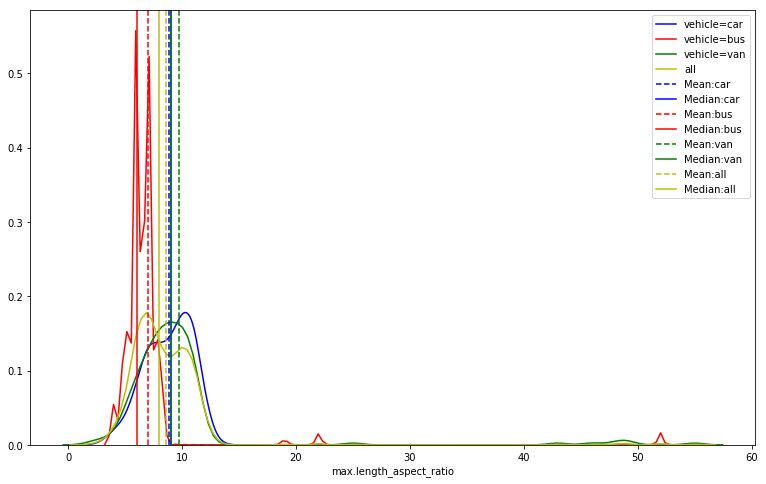

In [92]:
draw_distplot("max.length_aspect_ratio")

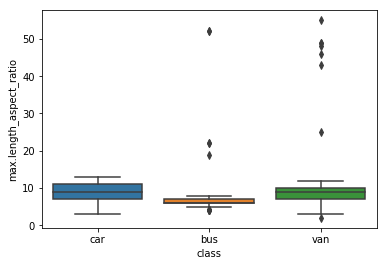

In [93]:
draw_boxplot("max.length_aspect_ratio")

In [94]:
# Let's grab the outliers from bus category.
outliers = grab_outliers_IQR(bus, "max.length_aspect_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
4             85         44.0                  70.0         205.0   
100           82         45.0                  66.0         252.0   
127           85         41.0                  66.0         155.0   
171          106         54.0                  96.5         161.0   
213          104         49.0                  89.0         168.0   
375          109         52.0                  95.0         189.0   
381          106         54.0                  96.5         227.0   
444          102         53.0                  96.5         238.0   
472          105         50.0                  93.0         173.0   
544           88         43.0                  70.0         177.0   
777          106         53.0                  96.5         154.0   
815           81         45.0                  68.0         154.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
4                    88.5                       52          149.0   
100                  88.5                       52          148.0   
127                  65.0                       22          149.0   
171                  47.0                        4          247.0   
213                  54.0                        4          212.0   
375                  58.0                        4          227.0   
381                  67.0                        4          250.0   
444                  72.0                        4          238.0   
472                  54.0                        4          222.0   
544                  74.0                       19          152.0   
777                  47.0                        4          237.0   
815                  69.0                       22          151.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
4             45.0                    19.0                        144   
100           45.0                    19.0                        144   
127           45.0                    19.0                        139   
171           27.0                    27.0                        166   
213           31.0                    24.0                        153   
375           29.0                    25.0                        158   
381           27.0                    27.0                        162   
444           28.0                    26.0                        163   
472           30.0                    25.0                        159   
544           44.0                    19.0                        143   
777           28.0                    26.0                        164   
815           45.0                    19.0                        147   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
4              241.0              325.0                      188.0   
100            237.0              326.0                      185.0   
127            173.0              330.0                      155.0   
171            266.0              892.0                      242.0   
213            238.0              682.0                      198.0   
375            262.0              776.0                      217.0   
381            280.0              923.0                      262.0   
444            267.0              844.0                      242.0   
472            254.0              735.0                      206.0   
544            180.0              342.0                      168.0   
777            263.0              838.0                      222.0   
815            186.0              335.0                      186.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
4                          127.0             9.0              11.0   
100                        119.0             1.0               1.0   
127                         75.0             6.0              16.0   
171                         85.0             4.0              11.0  

In [95]:
# Let's assess outliers from bus category. 
# Highlight other features that are 10% away from mean
consolidated = highlight_other_features(outliers, bus, "bus")
consolidated

In [96]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value

_, lower, upper = get_IQR(bus, 'max.length_aspect_ratio')

upper_list = outliers[outliers['max.length_aspect_ratio'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_aspect_ratio'] = upper

lower_list = outliers[outliers['max.length_aspect_ratio'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_aspect_ratio'] = lower

car, bus, van = refresh_datasets(vehicles)


In [97]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "max.length_aspect_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [98]:
# Let's grab the outliers from van category.
outliers = grab_outliers_IQR(van, "max.length_aspect_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
37            90         48.0                  86.0        198.75   
135           89         47.0                  83.0        198.75   
291           89         45.0                  81.0        198.75   
388           94         47.0                  85.0        198.75   
391           91         38.0                  70.0        160.00   
523           90         43.0                  81.0        198.75   
655           86         35.0                  44.0        110.00   
706           82         43.0                  70.0        198.75   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
37                   76.0                     49.0          153.0   
135                  76.0                     48.0          158.0   
291                  76.0                     43.0          155.0   
388                  76.0                     49.0          155.0   
391                  66.0                     25.0          140.0   
523                  76.0                     46.0          150.0   
655                  54.0                      2.0          119.0   
706                  76.0                     55.0          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
37            44.0                    19.0                        156   
135           43.0                    20.0                        163   
291           44.0                    20.0                        160   
388           43.0                    19.0                        155   
391           47.0                    18.0                        139   
523           45.0                    19.0                        149   
655           57.0                    17.0                        121   
706           48.0                    18.0                        145   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
37             272.0              346.0                      200.0   
135            229.0              364.0                      176.0   
291            200.0              347.0                      177.0   
388            320.0              354.0                      187.0   
391            162.0              296.0                      130.0   
523            200.0              332.0                      164.0   
655            139.0              208.0                      137.0   
706            231.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
37                         118.0             0.0              15.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
391                         67.0             4.0              11.0   
523                         91.0             5.0               9.0   
655                         90.0             6.0               1.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
37              185.0            194   van  
135             184.0            194   van  
291             183.0            192   van  
388             188.0            196   van  
391             192.0            202   van  
523             186.0            196   van  
655             180.0            183   van  
706             190.0            199   van

In [99]:
# Let's assess outliers from van category. 
# Highlight other features that are 10% away from mean.
consolidated = highlight_other_features(outliers, van, "van")
consolidated

In [100]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(van, 'max.length_aspect_ratio')

upper_list = outliers[outliers['max.length_aspect_ratio'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_aspect_ratio'] = upper

lower_list = outliers[outliers['max.length_aspect_ratio'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_aspect_ratio'] = lower

car, bus, van = refresh_datasets(vehicles)

In [101]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "max.length_aspect_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [102]:
get_high_corrleation_features(vehicles, "max.length_aspect_ratio", THRESHOLD_CORR)
# Wov 10 other features are correlated

max.length_aspect_ratio
distance_circularity                      0.669033
max.length_rectangularity                 0.633041
circularity                               0.554403
radius_ratio                              0.476004
compactness                               0.471686
scatter_ratio                             0.465375
pr.axis_rectangularity                    0.461985
scaled_variance                           0.426114
scaled_variance.1                         0.425679
elongatedness                            -0.481121

## [7] scatter_ratio
1. Variable type: float64, continuous
2. 1 missing values
3. (inertia about minor axis)/(inertia about major axis) 

In [103]:
# Let's first locate the records with missing values
vehicles[vehicles['scatter_ratio'].isna()][['scatter_ratio', 'class']]
# 1 record [Index = 249] is for car 

scatter_ratio class
249            NaN   car

In [104]:
# Let's impute it with the mean values for the corresponding class
vehicles.loc[[249], 'scatter_ratio'] = car['scatter_ratio'].mean()

In [105]:
# Let's validate
vehicles.loc[[249]][['scatter_ratio', 'class']]

scatter_ratio class
249     181.053738   car

In [106]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

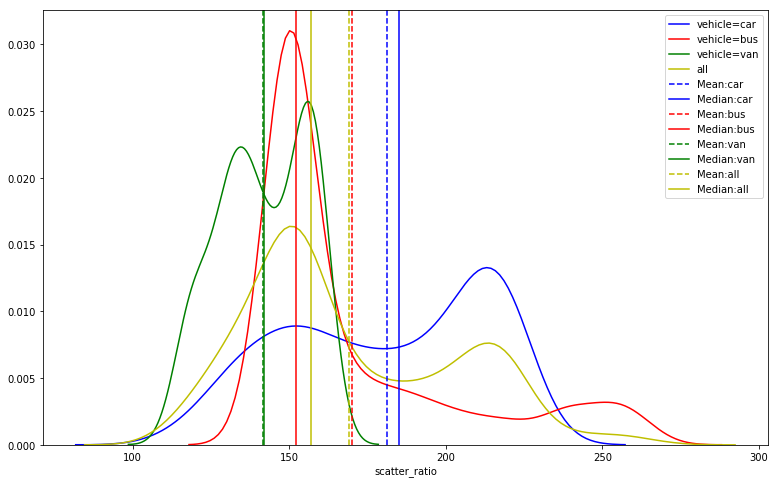

In [107]:
# Let's draw the plots
draw_distplot("scatter_ratio")

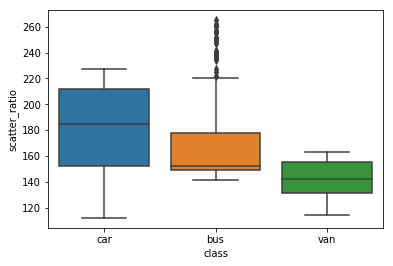

In [108]:
draw_boxplot("scatter_ratio")

In [109]:
# Let's grab the outliers from bus category.
outliers = grab_outliers_IQR(bus, "scatter_ratio")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308                  96.5    172.000000   
54           101    54.500000                  96.5    185.000000   
85           110    54.500000                  96.5    180.000000   
155          110    54.500000                  96.5    223.000000   
171          106    54.000000                  96.5    161.000000   
193          107    54.500000                  96.5    199.000000   
274          107    54.500000                  96.5    179.000000   
294          109    54.500000                  96.5    169.000000   
321          113    54.500000                  96.5    194.000000   
334          107    54.500000                  96.5    184.000000   
345          101    54.000000                  96.5    165.708333   
375          109    52.000000                  95.0    189.000000   
381          106    54.000000                  96.5    227.000000   
396          108    44.981308                  96.5    177.000000   
444          102    53.000000                  96.5    238.000000   
472          105    50.000000                  93.0    173.000000   
494          106    54.000000                  96.5    164.000000   
531          107    54.500000                  96.5    167.000000   
539          109    54.500000                  96.0    191.000000   
556          108    54.500000                  96.5    246.000000   
683          110    54.500000                  96.5    199.000000   
687          106    54.500000                  96.5    235.000000   
710          102    54.000000                  96.5    201.000000   
731          103    52.000000                  96.5    170.000000   
733          114    54.500000                  96.5    181.000000   
777          106    53.000000                  96.5    154.000000   
835          111    54.500000                  96.5    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0          255.0   
54                   53.0                      6.0          257.0   
85                   51.0                      6.0          261.0   
155                  64.0                      5.0          250.0   
171                  47.0                      4.5          247.0   
193                  59.0                      7.0          240.0   
274                  51.0                      8.0          257.0   
294                  51.0                      6.0          241.0   
321                  56.0                      6.0          260.0   
334                  55.0                      7.0          234.0   
345                  57.0                      7.0          236.0   
375                  58.0                      4.5          227.0   
381                  67.0                      4.5          250.0   
396                  51.0                      5.0          256.0   
444                  72.0                      4.5          238.0   
472                  54.0                      4.5          222.0   
494                  48.0                      5.0          247.0   
531                  49.0                      7.0          252.0   
539                  57.0                      6.0          241.0   
556                  75.0                      6.0          239.0   
683                  57.0                      5.0          251.0   
687                  67.0                      6.0          262.0   
710                  61.0                      6.0          225.0   
731                  52.0                      7.0          236.0   
733                  52.0                      6.0          257.0   
777                  47.0                      4.5          237.0   
835                  51.0                      6.0          265.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    28.0                        

In [110]:
# Let's replace the outlier with upper whisker
_, lower, upper = get_IQR(bus, 'scatter_ratio')
vehicles.loc[outliers.index.tolist(), 'scatter_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [111]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scatter_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

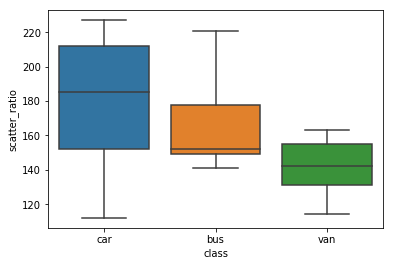

In [112]:
draw_boxplot("scatter_ratio")

In [113]:
get_high_corrleation_features(vehicles, "scatter_ratio", THRESHOLD_CORR)
# Wov 11 other features are correlated

scatter_ratio
scaled_variance.1               0.977091
pr.axis_rectangularity          0.976418
scaled_variance                 0.930273
distance_circularity            0.908496
circularity                     0.851355
max.length_rectangularity       0.814027
compactness                     0.811488
radius_ratio                    0.800168
scaled_radius_of_gyration       0.783355
max.length_aspect_ratio         0.516954
elongatedness                  -0.974818

## [8] elongatedness
1. Variable type: float64, continuous
2. 1 missing values
3. area/(shrink width)**2 

In [114]:
# Let's first locate the records with missing values
vehicles[vehicles['elongatedness'].isna()][['elongatedness', 'class']]
# 1 record [Index = 215] is for car 

elongatedness class
215            NaN   car

In [115]:
vehicles.loc[215, 'elongatedness'] = car['elongatedness'].mean()

In [116]:
# Let's validate
vehicles.loc[215, 'elongatedness']

38.09345794392523

In [117]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

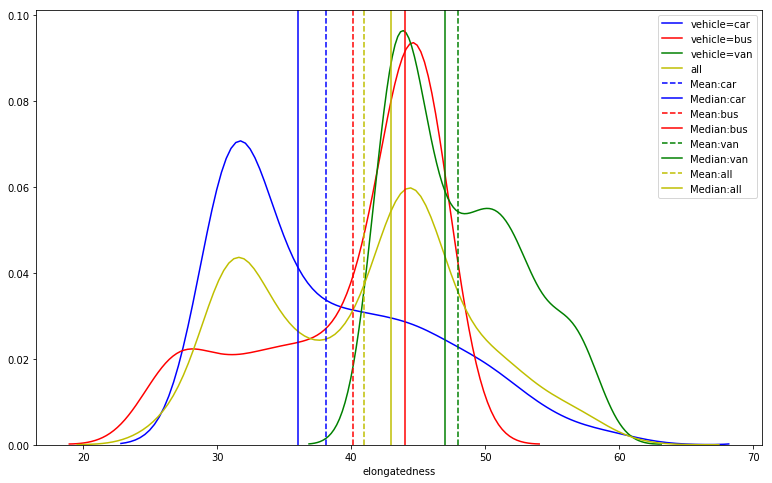

In [118]:
draw_distplot("elongatedness")

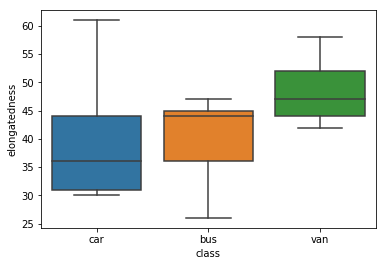

In [119]:
draw_boxplot("elongatedness")

1. car have pretty wide range of elongatedness; especially stretched in Q3 and Q4. Some cars have very high elongatedness (Upper whisker). Indicated by long right tail.
2. bus too have pretty wide elongatedness; especially in Q1 and Q2. This is indicated by long left tail. Q3 is pretty narrow hence showing peak in distplot.
3. van have higher elongatedness than car and bus. But the distribution is quite normal. Q3 & Q4 are more stretched compared to Q1 and Q2.

In [120]:
get_high_corrleation_features(vehicles, "elongatedness", THRESHOLD_CORR)
# Wov 11 other features are correlated

elongatedness
max.length_aspect_ratio        -0.480763
scaled_radius_of_gyration      -0.765917
max.length_rectangularity      -0.774955
compactness                    -0.788389
circularity                    -0.819719
radius_ratio                   -0.833081
distance_circularity           -0.901748
scaled_variance                -0.938297
pr.axis_rectangularity         -0.950205
scaled_variance.1              -0.956237
scatter_ratio                  -0.974637

## [9] pr.axis_rectangularity
1. Variable type: float64, continuous
2. 3 missing values
3. area/(pr.axis length*pr.axis width) 

In [121]:
# Let's first locate the records with missing values
vehicles[vehicles['pr.axis_rectangularity'].isna()][['pr.axis_rectangularity', 'class']]
# 1 record [Index = 70] is for car, 1 for bus and 1 for van

pr.axis_rectangularity class
70                      NaN   car
237                     NaN   bus
273                     NaN   van

In [122]:
vehicles.loc[70, 'pr.axis_rectangularity'] = car['pr.axis_rectangularity'].mean()
vehicles.loc[237, 'pr.axis_rectangularity'] = bus['pr.axis_rectangularity'].mean()
vehicles.loc[273, 'pr.axis_rectangularity'] = van['pr.axis_rectangularity'].mean()

In [123]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

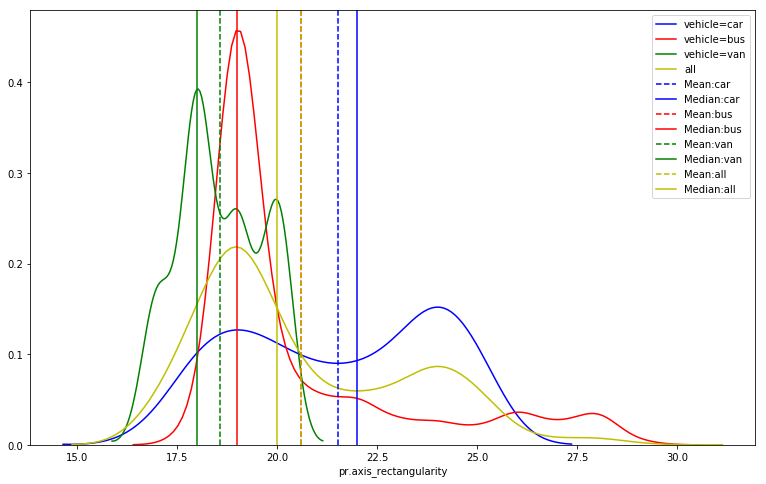

In [124]:
draw_distplot("pr.axis_rectangularity")

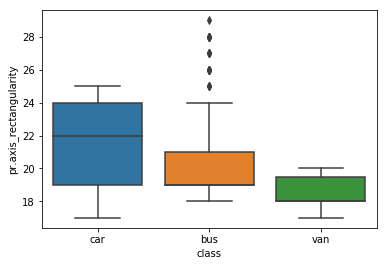

In [125]:
draw_boxplot("pr.axis_rectangularity")

In [126]:
outliers = grab_outliers_IQR(bus, "pr.axis_rectangularity")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308             96.500000    172.000000   
54           101    54.500000             96.500000    185.000000   
85           110    54.500000             96.500000    180.000000   
155          110    54.500000             96.500000    223.000000   
171          106    54.000000             96.500000    161.000000   
193          107    54.500000             96.500000    199.000000   
274          107    54.500000             96.500000    179.000000   
294          109    54.500000             96.500000    169.000000   
319          102    51.000000             76.767442    194.000000   
321          113    54.500000             96.500000    194.000000   
334          107    54.500000             96.500000    184.000000   
345          101    54.000000             96.500000    165.708333   
375          109    52.000000             95.000000    189.000000   
381          106    54.000000             96.500000    227.000000   
396          108    44.981308             96.500000    177.000000   
444          102    53.000000             96.500000    238.000000   
472          105    50.000000             93.000000    173.000000   
494          106    54.000000             96.500000    164.000000   
531          107    54.500000             96.500000    167.000000   
539          109    54.500000             96.000000    191.000000   
556          108    54.500000             96.500000    246.000000   
683          110    54.500000             96.500000    199.000000   
687          106    54.500000             96.500000    235.000000   
710          102    54.000000             96.500000    201.000000   
731          103    52.000000             96.500000    170.000000   
733          114    54.500000             96.500000    181.000000   
777          106    53.000000             96.500000    154.000000   
835          111    54.500000             96.500000    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0        220.875   
54                   53.0                      6.0        220.875   
85                   51.0                      6.0        220.875   
155                  64.0                      5.0        220.875   
171                  47.0                      4.5        220.875   
193                  59.0                      7.0        220.875   
274                  51.0                      8.0        220.875   
294                  51.0                      6.0        220.875   
319                  60.0                      6.0        220.000   
321                  56.0                      6.0        220.875   
334                  55.0                      7.0        220.875   
345                  57.0                      7.0        220.875   
375                  58.0                      4.5        220.875   
381                  67.0                      4.5        220.875   
396                  51.0                      5.0        220.875   
444                  72.0                      4.5        220.875   
472                  54.0                      4.5        220.875   
494                  48.0                      5.0        220.875   
531                  49.0                      7.0        220.875   
539                  57.0                      6.0        220.875   
556                  75.0                      6.0        220.875   
683                  57.0                      5.0        220.875   
687                  67.0                      6.0        220.875   
710                  61.0                      6.0        220.875   
731                  52.0                      7.0        220.875   
733                  52.0                      6.0        220.875   
777                  47.0                      4.5        220.875   
835                  51.0                      6.0        220.875   

 

In [127]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'pr.axis_rectangularity')
vehicles.loc[outliers.index.tolist(), 'pr.axis_rectangularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [128]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "pr.axis_rectangularity")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [129]:
get_high_corrleation_features(vehicles, "pr.axis_rectangularity", THRESHOLD_CORR)
# Wov 11 other features are correlated

pr.axis_rectangularity
scatter_ratio                            0.987744
scaled_variance.1                        0.965004
scaled_variance                          0.907895
distance_circularity                     0.906189
circularity                              0.852199
max.length_rectangularity                0.821435
compactness                              0.812546
radius_ratio                             0.784637
scaled_radius_of_gyration                0.775121
max.length_aspect_ratio                  0.539239
elongatedness                           -0.954588

## [10] max.length_rectangularity
1. Variable type: int64, continuous
2. 0 missing values
3. area/(max.length*length perp. to this)  

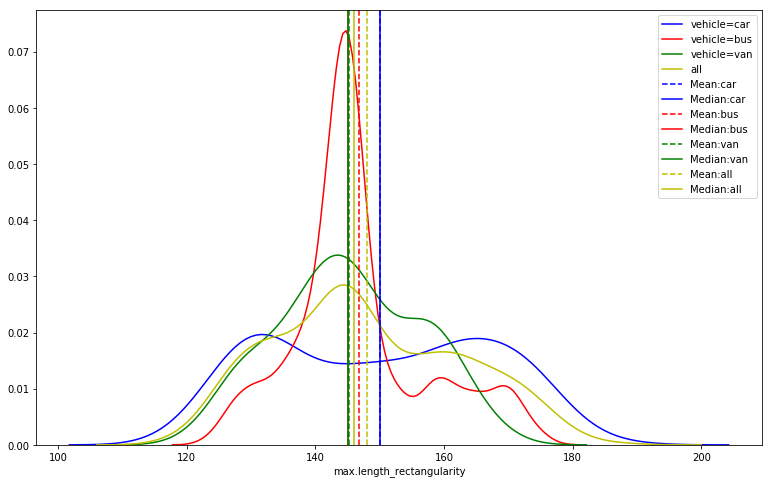

In [130]:
draw_distplot("max.length_rectangularity")

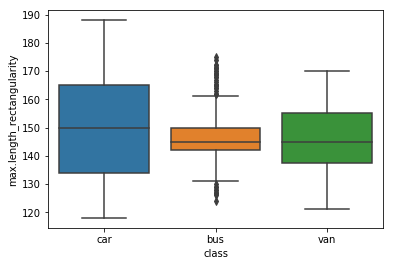

In [131]:
draw_boxplot("max.length_rectangularity")

In [132]:
outliers = grab_outliers_IQR(bus, "max.length_rectangularity")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308             96.500000    172.000000   
54           101    54.500000             96.500000    185.000000   
85           110    54.500000             96.500000    180.000000   
155          110    54.500000             96.500000    223.000000   
171          106    54.000000             96.500000    161.000000   
193          107    54.500000             96.500000    199.000000   
236           96    37.000000             74.000000    199.000000   
246           95    36.000000             73.000000    191.000000   
274          107    54.500000             96.500000    179.000000   
279           94    37.000000             73.000000    186.000000   
294          109    54.500000             96.500000    169.000000   
319          102    51.000000             76.767442    194.000000   
321          113    54.500000             96.500000    194.000000   
334          107    54.500000             96.500000    184.000000   
345          101    54.000000             96.500000    165.708333   
381          106    54.000000             96.500000    227.000000   
396          108    44.981308             96.500000    177.000000   
417           96    36.000000             74.000000    183.000000   
444          102    53.000000             96.500000    238.000000   
494          106    54.000000             96.500000    164.000000   
531          107    54.500000             96.500000    167.000000   
539          109    54.500000             96.000000    191.000000   
556          108    54.500000             96.500000    246.000000   
564           98    35.000000             70.000000    182.000000   
613           92    37.000000             75.000000    191.000000   
646           90    38.000000             79.000000    185.000000   
683          110    54.500000             96.500000    199.000000   
687          106    54.500000             96.500000    235.000000   
710          102    54.000000             96.500000    201.000000   
733          114    54.500000             96.500000    181.000000   
737          105    51.000000             93.000000    160.000000   
752          100    36.000000             73.000000    199.000000   
775           97    38.000000             75.000000    188.000000   
777          106    53.000000             96.500000    154.000000   
830           97    37.000000             70.000000    173.000000   
835          111    54.500000             96.500000    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0        220.875   
54                   53.0                      6.0        220.875   
85                   51.0                      6.0        220.875   
155                  64.0                      5.0        220.875   
171                  47.0                      4.5        220.875   
193                  59.0                      7.0        220.875   
236                  74.0                      5.0        165.000   
246                  73.0                      6.0        156.000   
274                  51.0                      8.0        220.875   
279                  71.0                      7.0        154.000   
294                  51.0                      6.0        220.875   
319                  60.0                      6.0        220.000   
321                  56.0                      6.0        220.875   
334                  55.0                      7.0        220.875   
345                  57.0                      7.0        220.875   
381                  67.0                      4.5        220.875   
396                  51.0                      5.0        220.875   
417                  70.0                      6.0        149.000   
444                  72.0                      4.5        220.875   
494                  48.0                      5.0        220.875   
53

In [133]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(bus, 'max.length_rectangularity')

upper_list = outliers[outliers['max.length_rectangularity'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_rectangularity'] = upper

lower_list = outliers[outliers['max.length_rectangularity'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_rectangularity'] = lower

car, bus, van = refresh_datasets(vehicles)

In [134]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "max.length_rectangularity")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [135]:
get_high_corrleation_features(vehicles, "max.length_rectangularity", THRESHOLD_CORR)
# Wov 11 other features are correlated

max.length_rectangularity
circularity                                 0.959478
scaled_radius_of_gyration                   0.849523
pr.axis_rectangularity                      0.816563
scatter_ratio                               0.806347
scaled_variance.1                           0.774394
distance_circularity                        0.768933
scaled_variance                             0.723620
compactness                                 0.666065
max.length_aspect_ratio                     0.657414
radius_ratio                                0.589221
elongatedness                              -0.765271

## [11] scaled_variance
1. Variable type: float64, continuous
2. 3 missing values
3. (2nd order moment about minor axis)/area ALONG MAJOR AXIS

In [136]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_variance'].isna()][['scaled_variance', 'class']]

scaled_variance class
105              NaN   car
372              NaN   van
522              NaN   car

In [137]:
# Let's fix
vehicles.loc[[105, 522], 'scaled_variance'] = car['scaled_variance'].mean()
vehicles.loc[[372], 'scaled_variance'] = van['scaled_variance'].mean()

In [138]:
# Let's validate
vehicles.loc[[105, 372, 522], 'scaled_variance']

105    197.894614
372    163.964646
522    197.894614
Name: scaled_variance, dtype: float64

In [139]:
car, bus, van = refresh_datasets(vehicles)

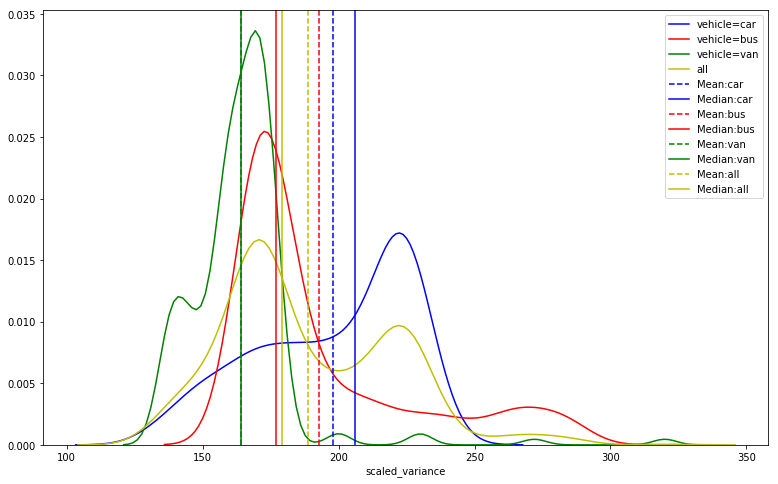

In [140]:
draw_distplot("scaled_variance")

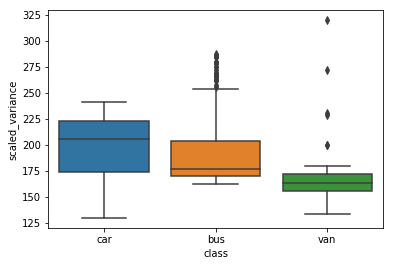

In [141]:
draw_boxplot("scaled_variance")

In [142]:
# Let's pull the outliers for bus
outliers = grab_outliers_IQR(bus, "scaled_variance")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308                  96.5    172.000000   
54           101    54.500000                  96.5    185.000000   
85           110    54.500000                  96.5    180.000000   
155          110    54.500000                  96.5    223.000000   
171          106    54.000000                  96.5    161.000000   
193          107    54.500000                  96.5    199.000000   
274          107    54.500000                  96.5    179.000000   
294          109    54.500000                  96.5    169.000000   
321          113    54.500000                  96.5    194.000000   
345          101    54.000000                  96.5    165.708333   
375          109    52.000000                  95.0    189.000000   
381          106    54.000000                  96.5    227.000000   
396          108    44.981308                  96.5    177.000000   
444          102    53.000000                  96.5    238.000000   
494          106    54.000000                  96.5    164.000000   
531          107    54.500000                  96.5    167.000000   
539          109    54.500000                  96.0    191.000000   
556          108    54.500000                  96.5    246.000000   
683          110    54.500000                  96.5    199.000000   
687          106    54.500000                  96.5    235.000000   
733          114    54.500000                  96.5    181.000000   
777          106    53.000000                  96.5    154.000000   
835          111    54.500000                  96.5    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0        220.875   
54                   53.0                      6.0        220.875   
85                   51.0                      6.0        220.875   
155                  64.0                      5.0        220.875   
171                  47.0                      4.5        220.875   
193                  59.0                      7.0        220.875   
274                  51.0                      8.0        220.875   
294                  51.0                      6.0        220.875   
321                  56.0                      6.0        220.875   
345                  57.0                      7.0        220.875   
375                  58.0                      4.5        220.875   
381                  67.0                      4.5        220.875   
396                  51.0                      5.0        220.875   
444                  72.0                      4.5        220.875   
494                  48.0                      5.0        220.875   
531                  49.0                      7.0        220.875   
539                  57.0                      6.0        220.875   
556                  75.0                      6.0        220.875   
683                  57.0                      5.0        220.875   
687                  67.0                      6.0        220.875   
733                  52.0                      6.0        220.875   
777                  47.0                      4.5        220.875   
835                  51.0                      6.0        220.875   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    24.0                    161.375   
54            26.0                    24.0                    161.375   
85            26.0                    24.0                    161.375   
155           26.0                    24.0                    161.375   
171           27.0                    24.0                    161.375   
193           27.0                    24.0                    161.375   
274           26.0                    24.0                    161.375   
294           27.0                    24.0                    161.375   
321           26.0                

In [143]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_variance')
vehicles.loc[outliers.index.tolist(), 'scaled_variance'] = upper
car, bus, van = refresh_datasets(vehicles)

In [144]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_variance")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [145]:
# Let's pull the outliers for van
outliers = grab_outliers_IQR(van, "scaled_variance")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
37            90         48.0                  86.0        198.75   
135           89         47.0                  83.0        198.75   
291           89         45.0                  81.0        198.75   
388           94         47.0                  85.0        198.75   
523           90         43.0                  81.0        198.75   
706           82         43.0                  70.0        198.75   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
37                   76.0                     14.5          153.0   
135                  76.0                     14.5          158.0   
291                  76.0                     14.5          155.0   
388                  76.0                     14.5          155.0   
523                  76.0                     14.5          150.0   
706                  76.0                     14.5          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
37            44.0                    19.0                      156.0   
135           43.0                    20.0                      163.0   
291           44.0                    20.0                      160.0   
388           43.0                    19.0                      155.0   
523           45.0                    19.0                      149.0   
706           48.0                    18.0                      145.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
37             272.0              346.0                      200.0   
135            229.0              364.0                      176.0   
291            200.0              347.0                      177.0   
388            320.0              354.0                      187.0   
523            200.0              332.0                      164.0   
706            231.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
37                         118.0             0.0              15.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
523                         91.0             5.0               9.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
37              185.0            194   van  
135             184.0            194   van  
291             183.0            192   van  
388             188.0            196   van  
523             186.0            196   van  
706             190.0            199   van

In [146]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'scaled_variance')
vehicles.loc[outliers.index.tolist(), 'scaled_variance'] = upper
car, bus, van = refresh_datasets(vehicles)

In [147]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "scaled_variance")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [148]:
get_high_corrleation_features(vehicles, "scaled_variance", THRESHOLD_CORR)
# Wov 11 other features are correlated

scaled_variance
scaled_variance.1                 0.964485
scatter_ratio                     0.962731
pr.axis_rectangularity            0.943345
distance_circularity              0.874880
radius_ratio                      0.814707
circularity                       0.810705
compactness                       0.783330
scaled_radius_of_gyration         0.782817
max.length_rectangularity         0.744765
max.length_aspect_ratio           0.438308
elongatedness                    -0.967408

## [12] scaled_variance.1
1. Variable type: float64, continuous
2. 2 missing values
3. (2nd order moment about major axis)/area ALONG MINOR AXIS

In [149]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_variance.1'].isna()][['scaled_variance.1', 'class']]

scaled_variance.1 class
308                NaN   car
496                NaN   car

In [150]:
# Let's fix them
vehicles.loc[[308, 496], 'scaled_variance.1'] = car['scaled_variance.1'].mean()

In [151]:
# Let's validate
vehicles.loc[[308, 496], 'scaled_variance.1']

308    500.543326
496    500.543326
Name: scaled_variance.1, dtype: float64

In [152]:
car, bus, van = refresh_datasets(vehicles)

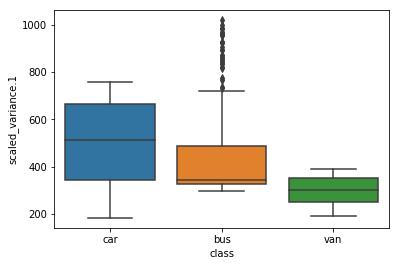

In [153]:
draw_boxplot("scaled_variance.1")

In [154]:
outliers = grab_outliers_IQR(bus, "scaled_variance.1")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308             96.500000    172.000000   
54           101    54.500000             96.500000    185.000000   
85           110    54.500000             96.500000    180.000000   
155          110    54.500000             96.500000    223.000000   
171          106    54.000000             96.500000    161.000000   
193          107    54.500000             96.500000    199.000000   
274          107    54.500000             96.500000    179.000000   
294          109    54.500000             96.500000    169.000000   
319          102    51.000000             76.767442    194.000000   
321          113    54.500000             96.500000    194.000000   
334          107    54.500000             96.500000    184.000000   
345          101    54.000000             96.500000    165.708333   
375          109    52.000000             95.000000    189.000000   
381          106    54.000000             96.500000    227.000000   
396          108    44.981308             96.500000    177.000000   
444          102    53.000000             96.500000    238.000000   
472          105    50.000000             93.000000    173.000000   
494          106    54.000000             96.500000    164.000000   
531          107    54.500000             96.500000    167.000000   
539          109    54.500000             96.000000    191.000000   
556          108    54.500000             96.500000    246.000000   
683          110    54.500000             96.500000    199.000000   
687          106    54.500000             96.500000    235.000000   
710          102    54.000000             96.500000    201.000000   
731          103    52.000000             96.500000    170.000000   
733          114    54.500000             96.500000    181.000000   
777          106    53.000000             96.500000    154.000000   
835          111    54.500000             96.500000    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0        220.875   
54                   53.0                      6.0        220.875   
85                   51.0                      6.0        220.875   
155                  64.0                      5.0        220.875   
171                  47.0                      4.5        220.875   
193                  59.0                      7.0        220.875   
274                  51.0                      8.0        220.875   
294                  51.0                      6.0        220.875   
319                  60.0                      6.0        220.000   
321                  56.0                      6.0        220.875   
334                  55.0                      7.0        220.875   
345                  57.0                      7.0        220.875   
375                  58.0                      4.5        220.875   
381                  67.0                      4.5        220.875   
396                  51.0                      5.0        220.875   
444                  72.0                      4.5        220.875   
472                  54.0                      4.5        220.875   
494                  48.0                      5.0        220.875   
531                  49.0                      7.0        220.875   
539                  57.0                      6.0        220.875   
556                  75.0                      6.0        220.875   
683                  57.0                      5.0        220.875   
687                  67.0                      6.0        220.875   
710                  61.0                      6.0        220.875   
731                  52.0                      7.0        220.875   
733                  52.0                      6.0        220.875   
777                  47.0                      4.5        220.875   
835                  51.0                      6.0        220.875   

 

In [155]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_variance.1')
vehicles.loc[outliers.index.tolist(), 'scaled_variance.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [156]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_variance.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

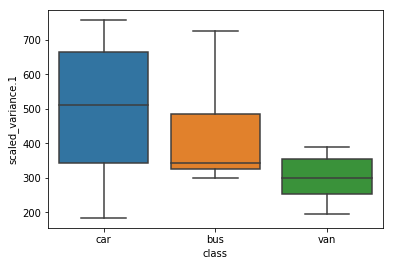

In [157]:
draw_boxplot("scaled_variance.1")

In [158]:
get_high_corrleation_features(vehicles, "scaled_variance.1", THRESHOLD_CORR)
# Wov there are 11 correlated features

scaled_variance.1
scatter_ratio                       0.994427
pr.axis_rectangularity              0.988478
scaled_variance                     0.962703
distance_circularity                0.900084
circularity                         0.849130
compactness                         0.822374
max.length_rectangularity           0.800609
radius_ratio                        0.798690
scaled_radius_of_gyration           0.782236
max.length_aspect_ratio             0.493269
elongatedness                      -0.967347

## [13] scaled_radius_of_gyration
1. Variable type: float64, continuous
2. 2 missing values
3. (mavar+mivar)/area

In [159]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_radius_of_gyration'].isna()][['scaled_radius_of_gyration', 'class']]

scaled_radius_of_gyration class
207                        NaN   bus
266                        NaN   bus

In [160]:
vehicles.loc[[207, 266], 'scaled_radius_of_gyration'] = bus['scaled_radius_of_gyration'].mean()

In [161]:
# Let's validate
vehicles.loc[[207, 266], 'scaled_radius_of_gyration']

207    181.032407
266    181.032407
Name: scaled_radius_of_gyration, dtype: float64

In [162]:
car, bus, van = refresh_datasets(vehicles)

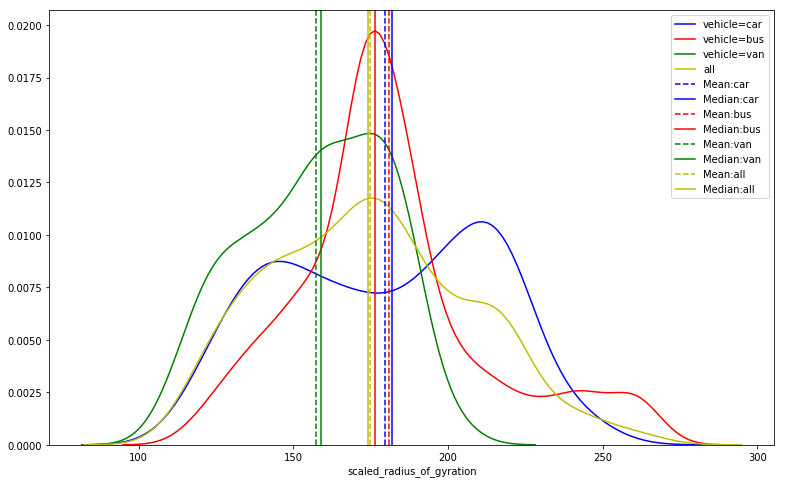

In [163]:
draw_distplot('scaled_radius_of_gyration')

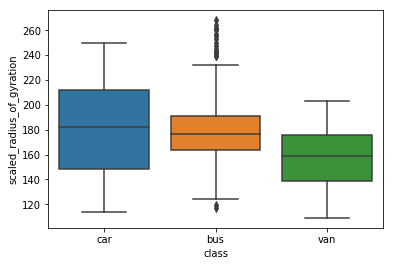

In [164]:
draw_boxplot('scaled_radius_of_gyration')

In [165]:
outliers = grab_outliers_IQR(bus, 'scaled_radius_of_gyration')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
5            107    44.981308                  96.5    172.000000   
85           110    54.500000                  96.5    180.000000   
155          110    54.500000                  96.5    223.000000   
171          106    54.000000                  96.5    161.000000   
193          107    54.500000                  96.5    199.000000   
294          109    54.500000                  96.5    169.000000   
321          113    54.500000                  96.5    194.000000   
345          101    54.000000                  96.5    165.708333   
381          106    54.000000                  96.5    227.000000   
396          108    44.981308                  96.5    177.000000   
444          102    53.000000                  96.5    238.000000   
494          106    54.000000                  96.5    164.000000   
531          107    54.500000                  96.5    167.000000   
539          109    54.500000                  96.0    191.000000   
564           98    35.000000                  70.0    182.000000   
683          110    54.500000                  96.5    199.000000   
687          106    54.500000                  96.5    235.000000   
731          103    52.000000                  96.5    170.000000   
733          114    54.500000                  96.5    181.000000   
830           97    37.000000                  70.0    173.000000   
835          111    54.500000                  96.5    183.000000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
5                    50.0                      6.0        220.875   
85                   51.0                      6.0        220.875   
155                  64.0                      5.0        220.875   
171                  47.0                      4.5        220.875   
193                  59.0                      7.0        220.875   
294                  51.0                      6.0        220.875   
321                  56.0                      6.0        220.875   
345                  57.0                      7.0        220.875   
381                  67.0                      4.5        220.875   
396                  51.0                      5.0        220.875   
444                  72.0                      4.5        220.875   
494                  48.0                      5.0        220.875   
531                  49.0                      7.0        220.875   
539                  57.0                      6.0        220.875   
564                  68.0                      5.0        155.000   
683                  57.0                      5.0        220.875   
687                  67.0                      6.0        220.875   
731                  52.0                      7.0        220.875   
733                  52.0                      6.0        220.875   
830                  66.0                      7.0        151.000   
835                  51.0                      6.0        220.875   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
5             26.0                    24.0                    161.375   
85            26.0                    24.0                    161.375   
155           26.0                    24.0                    161.375   
171           27.0                    24.0                    161.375   
193           27.0                    24.0                    161.375   
294           27.0                    24.0                    161.375   
321           26.0                    24.0                    161.375   
345           28.0                    24.0                    161.375   
381           27.0                    24.0                    161.375   
396           26.0                    24.0                    161.375   
444           28.0                    24.0                    161.375   
494           27.0                    24.0                    161.375   
531           27.0

In [166]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(bus, 'scaled_radius_of_gyration')

upper_list = outliers[outliers['scaled_radius_of_gyration'] > upper].index.tolist()
vehicles.loc[upper_list, 'scaled_radius_of_gyration'] = upper

lower_list = outliers[outliers['scaled_radius_of_gyration'] < lower].index.tolist()
vehicles.loc[lower_list, 'scaled_radius_of_gyration'] = lower

car, bus, van = refresh_datasets(vehicles)

In [167]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_radius_of_gyration")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [168]:
get_high_corrleation_features(vehicles, "scaled_radius_of_gyration", THRESHOLD_CORR)
# Wov 11 correlated features

scaled_radius_of_gyration
circularity                                 0.934013
max.length_rectangularity                   0.862213
scatter_ratio                               0.783445
scaled_variance.1                           0.780715
pr.axis_rectangularity                      0.777854
scaled_variance                             0.774577
distance_circularity                        0.693798
compactness                                 0.578211
radius_ratio                                0.563367
max.length_aspect_ratio                     0.415027
elongatedness                              -0.763273

## [14] scaled_radius_of_gyration.1
1. Variable type: float64, continuous
2. 4 missing values

In [169]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_radius_of_gyration.1'].isna()][['scaled_radius_of_gyration.1', 'class']]

scaled_radius_of_gyration.1 class
66                           NaN   bus
77                           NaN   car
192                          NaN   car
329                          NaN   car

In [170]:
vehicles.loc[[66], 'scaled_radius_of_gyration.1'] = bus['scaled_radius_of_gyration.1'].mean()
vehicles.loc[[77, 192, 329], 'scaled_radius_of_gyration.1'] = car['scaled_radius_of_gyration.1'].mean()

In [171]:
# Let's validate
vehicles.loc[[66, 77, 192, 329], 'scaled_radius_of_gyration.1']

66     77.096774
77     69.924883
192    69.924883
329    69.924883
Name: scaled_radius_of_gyration.1, dtype: float64

In [172]:
car, bus, van = refresh_datasets(vehicles)

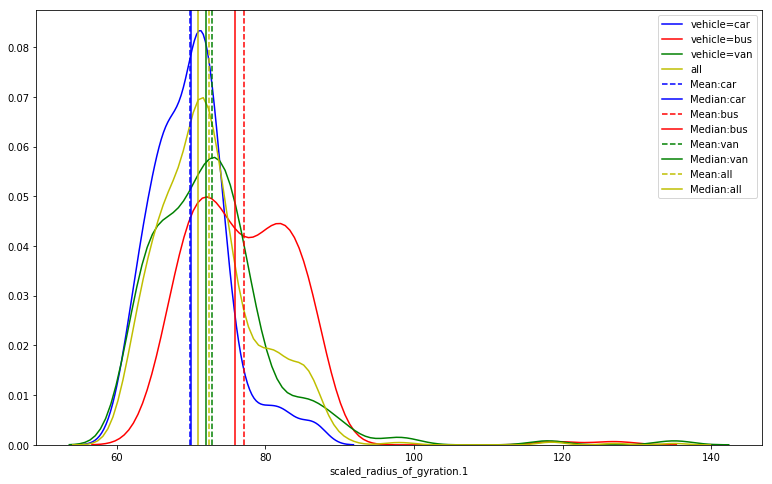

In [173]:
draw_distplot('scaled_radius_of_gyration.1')

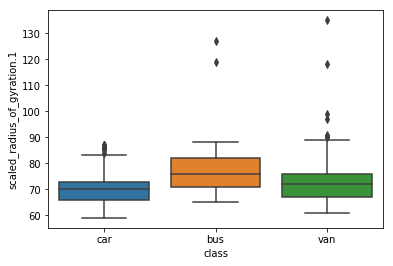

In [174]:
draw_boxplot("scaled_radius_of_gyration.1")

In [175]:
# Let's grab the outliers for car
outliers = grab_outliers_IQR(car, 'scaled_radius_of_gyration.1')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
160           82         38.0                  53.0         125.0   
231           85         33.0                  40.0         115.0   
342           83         37.0                  54.0         131.0   
351           88         38.0                  58.0         137.0   
411           78         36.0                  51.0         116.0   
463           85         40.0                  66.0         121.0   
515           76         38.0                  58.0         125.0   
612           80         34.0                  42.0         110.0   
834           82         36.0                  51.0         114.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
160                  59.0                      5.0          133.0   
231                  57.0                      3.0          112.0   
342                  61.0                      4.0          135.0   
351                  60.0                      5.0          148.0   
411                  56.0                      4.0          120.0   
463                  52.0                      4.0          152.0   
515                  58.0                      5.0          133.0   
612                  57.0                      3.0          114.0   
834                  53.0                      4.0          135.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
160           51.0                    18.0                      128.0   
231           61.0                    17.0                      119.0   
342           50.0                    18.0                      127.0   
351           46.0                    19.0                      131.0   
411           57.0                    17.0                      124.0   
463           44.0                    19.0                      133.0   
515           51.0                    18.0                      127.0   
612           59.0                    17.0                      119.0   
834           50.0                    18.0                      126.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
160            152.0              259.0                      146.0   
231            130.0              184.0                      127.0   
342            152.0              271.0                      141.0   
351            163.0              319.0                      157.0   
411            135.0              209.0                      135.0   
463            170.0              340.0                      163.0   
515            152.0              259.0                      145.0   
612            131.0              191.0                      121.0   
834            150.0              268.0                      144.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
160                         87.0             0.0               0.0   
231                         86.0            12.0              21.0   
342                         85.0             3.0               6.0   
351                         86.0            12.0               0.0   
411                         84.0             1.0              12.0   
463                         87.0            13.0               3.0   
515                         87.0             0.0              21.0   
612                         87.0             4.0               7.0   
834                         86.0            15.0               4.0   

     skewness_about.2  hollows_ratio class  
160             177.0            183   car  
231             181.0            183   car  
342             180.0            183   car  
351             180.0            183   car  
411             177.0            184   car  
463             180.0            183   car  
515             177.0            184   car  
612             179.0            183   car  
834             181.0            182   car

In [176]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(car, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [177]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(car, "scaled_radius_of_gyration.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [178]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, 'scaled_radius_of_gyration.1')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
4             85         44.0                  70.0         205.0   
100           82         45.0                  66.0         252.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
4                    88.5                      8.5          149.0   
100                  88.5                      8.5          148.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
4             45.0                    19.0                      144.0   
100           45.0                    19.0                      144.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
4              241.0              325.0                      188.0   
100            237.0              326.0                      185.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
4                          127.0             9.0              11.0   
100                        119.0             1.0               1.0   

     skewness_about.2  hollows_ratio class  
4               180.0            183   bus  
100             181.0            185   bus

In [179]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [180]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_radius_of_gyration.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [181]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, 'scaled_radius_of_gyration.1')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
37            90         48.0                  86.0        198.75   
135           89         47.0                  83.0        198.75   
291           89         45.0                  81.0        198.75   
388           94         47.0                  85.0        198.75   
523           90         43.0                  81.0        198.75   
655           86         35.0                  44.0        110.00   
706           82         43.0                  70.0        198.75   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
37                   76.0                     14.5          153.0   
135                  76.0                     14.5          158.0   
291                  76.0                     14.5          155.0   
388                  76.0                     14.5          155.0   
523                  76.0                     14.5          150.0   
655                  54.0                      2.5          119.0   
706                  76.0                     14.5          139.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
37            44.0                    19.0                      156.0   
135           43.0                    20.0                      163.0   
291           44.0                    20.0                      160.0   
388           43.0                    19.0                      155.0   
523           45.0                    19.0                      149.0   
655           57.0                    17.0                      121.0   
706           48.0                    18.0                      145.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
37             196.0              346.0                      200.0   
135            196.0              364.0                      176.0   
291            196.0              347.0                      177.0   
388            196.0              354.0                      187.0   
523            196.0              332.0                      164.0   
655            139.0              208.0                      137.0   
706            196.0              289.0                      172.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
37                         118.0             0.0              15.0   
135                         97.0             0.0              14.0   
291                         90.0             9.0              17.0   
388                        135.0            12.0               9.0   
523                         91.0             5.0               9.0   
655                         90.0             6.0               1.0   
706                         99.0             4.0               9.0   

     skewness_about.2  hollows_ratio class  
37              185.0            194   van  
135             184.0            194   van  
291             183.0            192   van  
388             188.0            196   van  
523             186.0            196   van  
655             180.0            183   van  
706             190.0            199   van

In [182]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [183]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "scaled_radius_of_gyration.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

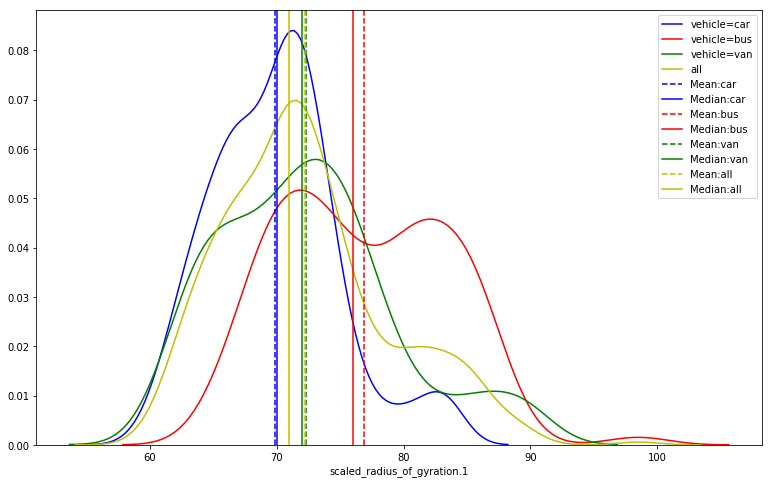

In [184]:
draw_distplot('scaled_radius_of_gyration.1')

In [185]:
get_high_corrleation_features(vehicles, 'scaled_radius_of_gyration.1', THRESHOLD_CORR)
# Only 2 other features are correlated

scaled_radius_of_gyration.1
skewness_about.2                    -0.828550
hollows_ratio                       -0.890593

## [15] skewness_about
1. Variable type: float64, continuous
2. 6 missing values

In [186]:
# Let's first locate the records with missing values
vehicles[vehicles['skewness_about'].isna()][['skewness_about', 'class']]

skewness_about class
66              NaN   bus
141             NaN   bus
177             NaN   bus
222             NaN   bus
249             NaN   car
285             NaN   car

In [187]:
# Let's impute with mean
vehicles.loc[[66, 141, 177, 222], 'skewness_about'] = bus['skewness_about'].mean()
vehicles.loc[[249, 285], 'skewness_about'] = car['skewness_about'].mean()

In [188]:
# Let's validate
vehicles.loc[[66, 141, 177, 222, 249, 285]][['skewness_about', 'class']]

skewness_about class
66         4.794393   bus
141        4.794393   bus
177        4.794393   bus
222        4.794393   bus
249        7.126464   car
285        7.126464   car

In [189]:
# Let's refresh
car, bus, van = refresh_datasets(vehicles)

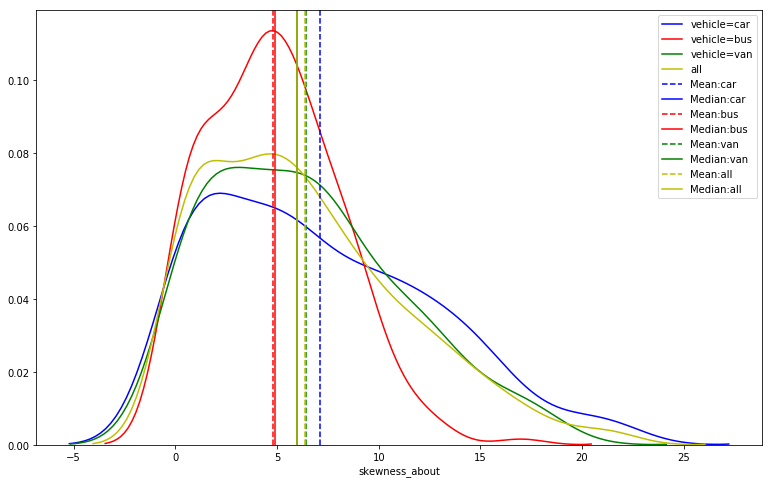

In [190]:
draw_distplot('skewness_about')

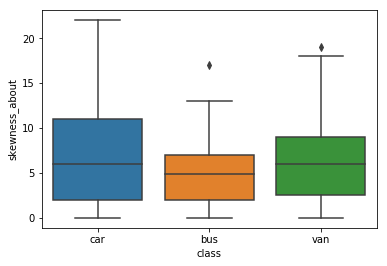

In [191]:
draw_boxplot('skewness_about')

In [192]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, "skewness_about")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
681           96         46.0                  70.0         194.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
681                  70.0                      6.0          167.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
681           39.0                    20.0                      148.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
681            183.0              427.0                      171.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
681                         69.0            17.0              10.0   

     skewness_about.2  hollows_ratio class  
681             200.0            203   bus

In [193]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'skewness_about')
vehicles.loc[outliers.index.tolist(), 'skewness_about'] = upper
car, bus, van = refresh_datasets(vehicles)

In [194]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "skewness_about")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [195]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, "skewness_about")
outliers

compactness  circularity  distance_circularity  radius_ratio  \
330           98         44.0                  78.0         160.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
330                  63.0                      8.0          142.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
330           47.0                    18.0                      148.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
330            160.0              300.0                      171.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
330                         63.0            19.0               2.0   

     skewness_about.2  hollows_ratio class  
330             201.0            207   van

In [196]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'skewness_about')
vehicles.loc[outliers.index.tolist(), 'skewness_about'] = upper
car, bus, van = refresh_datasets(vehicles)

In [197]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "skewness_about")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [198]:
get_high_corrleation_features(vehicles, 'skewness_about', THRESHOLD_CORR)
# No correlation with other features

Empty DataFrame
Columns: [skewness_about]
Index: []

## [16] skewness_about.1
1. Variable type: float64, continuous
2. 1 missing value

In [199]:
# Let's first locate the records with missing values
vehicles[vehicles['skewness_about.1'].isna()][['skewness_about.1', 'class']]

skewness_about.1 class
105               NaN   car

In [200]:
# Let's impute with mean
vehicles.loc[[105], 'skewness_about.1'] = car['skewness_about.1'].mean()

In [201]:
# Let's validate
vehicles.loc[[105], 'skewness_about.1']

105    15.170561
Name: skewness_about.1, dtype: float64

In [202]:
# Let's refresh
car, bus, van = refresh_datasets(vehicles)

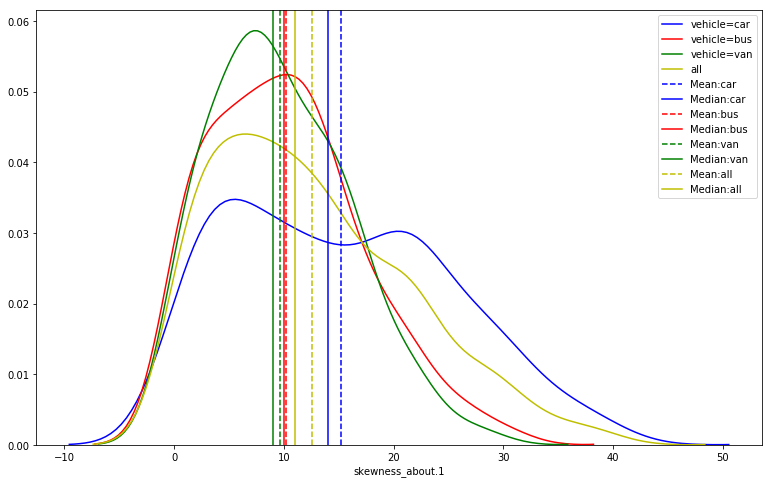

In [203]:
draw_distplot('skewness_about.1')

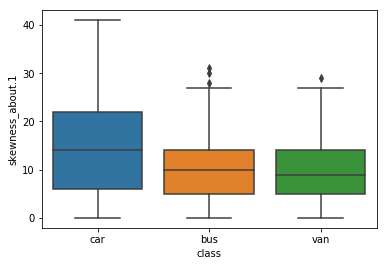

In [204]:
draw_boxplot('skewness_about.1')

In [205]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, 'skewness_about.1')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
173           96         49.0                  96.5         187.0   
531          107         54.5                  96.5         167.0   
687          106         54.5                  96.5         235.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
173                  59.0                      6.0        213.000   
531                  49.0                      7.0        220.875   
687                  67.0                      6.0        220.875   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
173           31.0                    24.0                    152.000   
531           27.0                    24.0                    161.375   
687           26.0                    24.0                    161.375   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
173          228.000             680.00                      210.0   
531          254.375             725.75                      232.0   
687          254.375             725.75                      232.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
173                         77.0             8.0              28.0   
531                         83.0             5.0              30.0   
687                         86.0             9.0              31.0   

     skewness_about.2  hollows_ratio class  
173             188.0            189   bus  
531             179.0            186   bus  
687             180.0            184   bus

In [206]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'skewness_about.1')
vehicles.loc[outliers.index.tolist(), 'skewness_about.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [207]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "skewness_about.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [208]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, 'skewness_about.1')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
149           93         36.0                  64.0         165.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
149                  69.0                      8.0          136.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
149           49.0                    18.0                      136.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
149            161.0              279.0                      127.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
149                         67.0             2.0              29.0   

     skewness_about.2  hollows_ratio class  
149             193.0            204   van

In [209]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'skewness_about.1')
vehicles.loc[outliers.index.tolist(), 'skewness_about.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [210]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "skewness_about.1")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

In [211]:
get_high_corrleation_features(vehicles, 'skewness_about.1', THRESHOLD_CORR)
# Even this doesn't have any correlation with other features

Empty DataFrame
Columns: [skewness_about.1]
Index: []

## [17] skewness_about.2
1. Variable type: float64, continuous
2. 1 value missing

In [212]:
# Let's first locate the records with missing values
vehicles[vehicles['skewness_about.2'].isna()][['skewness_about.2', 'class']]

skewness_about.2 class
419               NaN   car

In [213]:
# Let's impute with mean value
vehicles.loc[419, 'skewness_about.2'] = car['skewness_about.2'].mean()

In [214]:
# Let's validate
vehicles.loc[419, 'skewness_about.2']

189.47429906542055

In [215]:
# Let's refresh
car, bus, van = refresh_datasets(vehicles)

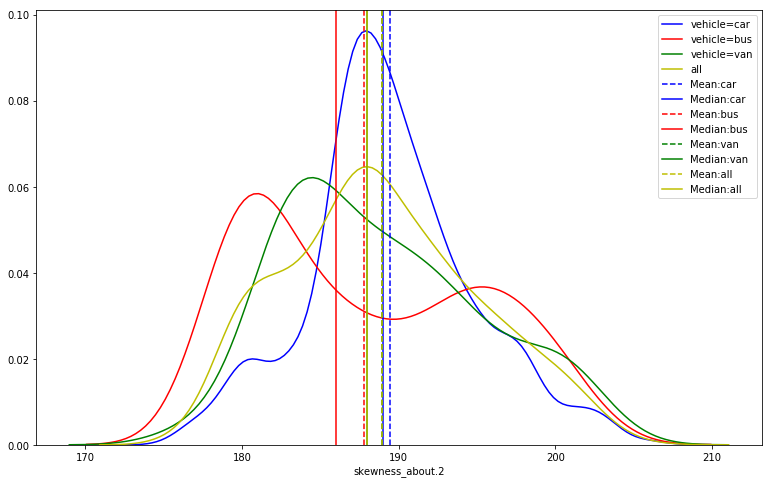

In [216]:
draw_distplot('skewness_about.2')

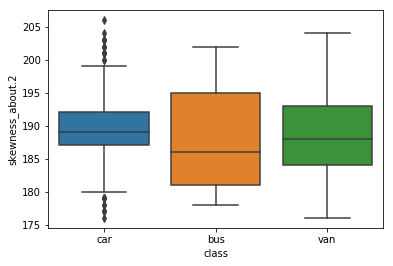

In [217]:
draw_boxplot('skewness_about.2')

In [218]:
# Let's grab the outliers for car
outliers = grab_outliers_IQR(car, 'skewness_about.2')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
26            83         36.0                  54.0         119.0   
73            73         37.0                  53.0         111.0   
89            80         37.0                  57.0         116.0   
140           90         37.0                  80.0         171.0   
148           90         43.0                  72.0         172.0   
152           93         35.0                  72.0         172.0   
160           82         38.0                  53.0         125.0   
166           92         36.0                  78.0         165.0   
181           78         36.0                  60.0         116.0   
210           94         39.0                  89.0         194.0   
326          106         49.0                  96.0         201.0   
347           88         44.0                  77.0         167.0   
349           89         40.0                  69.0         147.0   
367           82         37.0                  59.0         134.0   
380           80         39.0                  60.0         122.0   
406           80         38.0                  64.0         130.0   
411           78         36.0                  51.0         116.0   
422           90         34.0                  66.0         158.0   
515           76         38.0                  58.0         125.0   
516           92         42.0                  75.0         172.0   
578           92         46.0                  82.0         170.0   
612           80         34.0                  42.0         110.0   
614           85         33.0                  50.0         104.0   
615           88         34.0                  69.0         152.0   
634           81         38.0                  53.0         123.0   
636           96         41.0                  69.0         153.0   
652           97         37.0                  78.0         181.0   
654          100         47.0                  88.0         190.0   
690           94         40.0                  85.0         186.0   
840           93         34.0                  66.0         140.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
26                   57.0                      6.0          128.0   
73                   54.0                      6.0          126.0   
89                   55.0                      6.0          125.0   
140                  58.0                      9.0          157.0   
148                  59.0                      8.0          154.0   
152                  62.0                      7.0          149.0   
160                  59.0                      5.0          133.0   
166                  57.0                      8.0          153.0   
181                  56.0                      6.0          123.0   
210                  62.0                      9.0          172.0   
326                  61.0                     10.0          181.0   
347                  59.0                      6.0          151.0   
349                  58.0                      6.0          132.0   
367                  63.0                      7.0          135.0   
380                  56.0                      6.0          139.0   
406                  59.0                      8.0          134.0   
411                  56.0                      4.0          120.0   
422                  59.0                      7.0          140.0   
515                  58.0                      5.0          133.0   
516                  60.0                      8.0          147.0   
578                  58.0                      8.0          165.0   
612                  57.0                      3.0          114.0   
614                  53.0                      4.0          115.0   
615                  57.0                      5.0          138.0   
634                  58.0                      6.0          134.0   
636                  56.0                      7.0          141.0   
65

In [219]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(car, 'skewness_about.2')

upper_list = outliers[outliers['skewness_about.2'] > upper].index.tolist()
vehicles.loc[upper_list, 'skewness_about.2'] = upper

lower_list = outliers[outliers['skewness_about.2'] < lower].index.tolist()
vehicles.loc[lower_list, 'skewness_about.2'] = lower

car, bus, van = refresh_datasets(vehicles)

In [220]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(car, "skewness_about.2")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

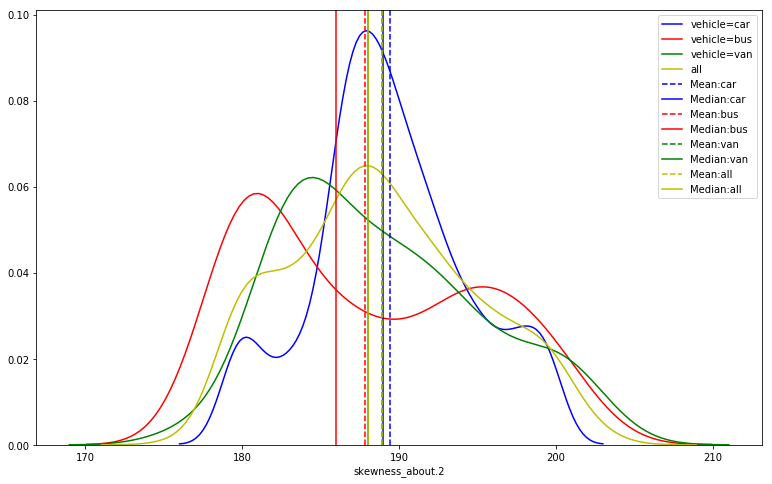

In [221]:
draw_distplot('skewness_about.2')

In [222]:
get_high_corrleation_features(vehicles, 'skewness_about.2', THRESHOLD_CORR)
# Just 3 correlated features

skewness_about.2
hollows_ratio                        0.892344
radius_ratio                         0.413178
scaled_radius_of_gyration.1         -0.827878

## [18] hollows_ratio
1. Variable type: int64, continuous
2. 0 value missing

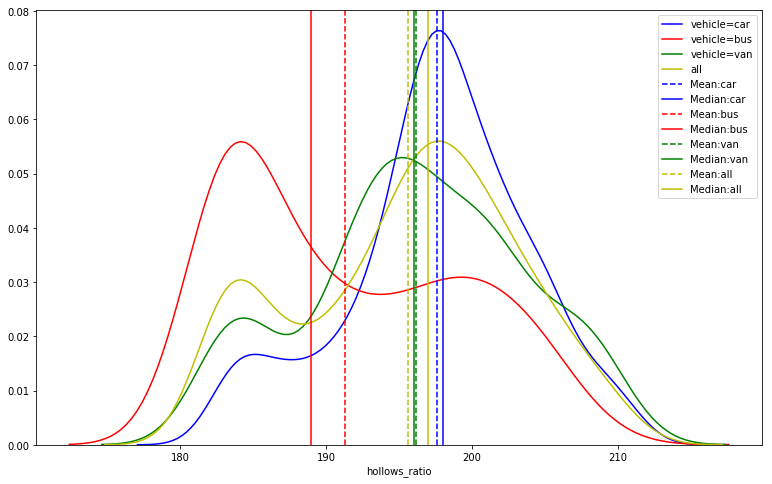

In [223]:
draw_distplot('hollows_ratio')

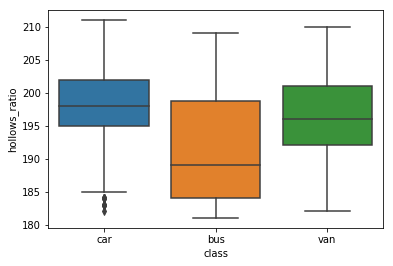

In [224]:
draw_boxplot('hollows_ratio')

In [225]:
# Grab the outliers for car
outliers = grab_outliers_IQR(car, 'hollows_ratio')
outliers

compactness  circularity  distance_circularity  radius_ratio  \
26            83         36.0                  54.0         119.0   
73            73         37.0                  53.0         111.0   
89            80         37.0                  57.0         116.0   
160           82         38.0                  53.0         125.0   
231           85         33.0                  40.0         115.0   
260           83         37.0                  54.0         118.0   
289           88         37.0                  57.0         132.0   
342           83         37.0                  54.0         131.0   
351           88         38.0                  58.0         137.0   
378           82         36.0                  54.0         117.0   
411           78         36.0                  51.0         116.0   
463           85         40.0                  66.0         121.0   
515           76         38.0                  58.0         125.0   
612           80         34.0                  42.0         110.0   
634           81         38.0                  53.0         123.0   
688           89         35.0                  52.0         121.0   
809           79         38.0                  55.0         120.0   
834           82         36.0                  51.0         114.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
26                   57.0                      6.0          128.0   
73                   54.0                      6.0          126.0   
89                   55.0                      6.0          125.0   
160                  59.0                      5.0          133.0   
231                  57.0                      3.0          112.0   
260                  55.0                      4.0          129.0   
289                  62.0                      6.0          135.0   
342                  61.0                      4.0          135.0   
351                  60.0                      5.0          148.0   
378                  53.0                      7.0          125.0   
411                  56.0                      4.0          120.0   
463                  52.0                      4.0          152.0   
515                  58.0                      5.0          133.0   
612                  57.0                      3.0          114.0   
634                  58.0                      6.0          134.0   
688                  57.0                      4.0          122.0   
809                  55.0                      5.0          142.0   
834                  53.0                      4.0          135.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
26            53.0                    18.0                      125.0   
73            55.0                    18.0                      128.0   
89            54.0                    18.0                      125.0   
160           51.0                    18.0                      128.0   
231           61.0                    17.0                      119.0   
260           52.0                    18.0                      127.0   
289           50.0                    18.0                      125.0   
342           50.0                    18.0                      127.0   
351           46.0                    19.0                      131.0   
378           54.0                    18.0                      126.0   
411           57.0                    17.0                      124.0   
463           44.0                    19.0                      133.0   
515           51.0                    18.0                      127.0   
612           59.0                    17.0                      119.0   
634           51.0                    18.0                      128.0   
688           55.0                    17.0                      125.0   
809           48.0                    19.0                      128.0   
834           50.0                    18.0                      126

In [226]:
# Let's replace these outliers with lower whisker
_, lower, upper = get_IQR(car, 'hollows_ratio')
vehicles.loc[outliers.index.tolist(), 'hollows_ratio'] = lower
car, bus, van = refresh_datasets(vehicles)

In [227]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(car, "hollows_ratio")
outliers

Empty DataFrame
Columns: [compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio, class]
Index: []

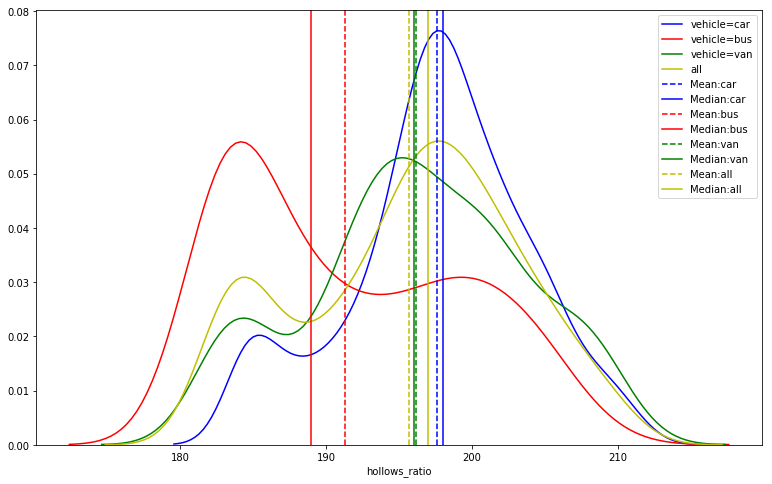

In [228]:
draw_distplot('hollows_ratio')

In [229]:
get_high_corrleation_features(vehicles, 'hollows_ratio', THRESHOLD_CORR)
# Just 3 of them

hollows_ratio
skewness_about.2                  0.892199
radius_ratio                      0.492671
scaled_radius_of_gyration.1      -0.890034

# Dimensionality Reduction - PCA

## [1] Which variables should be selected for PCA?

In [230]:
# In a single shot, let's find out which features are highly correlated
# Here I have highlighted the cells that have absolute value of correlation greather than THRESHOLD_CORR (0.4)
corr_df = vehicles.drop('class', axis=1).corr()
corr_df = corr_df.style.applymap(color_as_positive)
corr_df

According to above correlation matrix, we can easily leave out following features:
1. skewness_about
2. skewness_about.1

If we are more flexible in losing some more variance, then we can leave following feature(s) too.
3. pr.axis_aspect_ratio

## [2] Factors Loading 
    The coefficients in the factor equations are called the "factor loadings". These loadings have a lower limit of +1.0. The absolute values shows the strength of the relationship; the sign merely helps in assigning a name to the factor.

In [231]:
from sklearn.preprocessing import StandardScaler

In [232]:
# Let us build Factor Loadings manually

# Step-0: Standarize the columns
fields_not_needed_for_pca = ['class', 'skewness_about', 'skewness_about.1']

X = vehicles.drop(fields_not_needed_for_pca, axis=1)

# Let's scale using StandardScaler
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns=X.columns)
X_Scaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
0     0.160580     0.527227              0.072345      0.303349   
1    -0.325470    -0.625511              0.136876     -0.855035   
2     1.254193     0.856581              1.556551      1.273887   
3    -0.082445    -0.625511              0.007815     -0.291497   
4    -1.054545    -0.131481             -0.766554      1.148656   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              1.809414                 0.852456      -0.194077   
1             -0.734062                 0.385976      -0.606798   
2              0.792024                 0.852456       1.234572   
3              0.283328                 0.385976      -0.765537   
4              4.607238                 0.152736      -0.606798   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0       0.136999               -0.203770                   0.785782   
1       0.521243               -0.620505                  -0.339936   
2      -1.143812                1.046432                   0.715425   
3       0.649324               -0.620505                  -0.339936   
4       0.521243               -0.620505                  -0.269579   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0        -0.399474          -0.336786                   0.308264   
1        -0.602687          -0.635356                  -0.516429   
2         1.192356           1.223087                   1.450147   
3        -0.941374          -0.763314                  -1.499718   
4         1.801994          -0.665822                   0.435140   

   scaled_radius_of_gyration.1  skewness_about.2  hollows_ratio  
0                    -0.342052         -0.315004       0.181813  
1                    -0.037745          0.018222       0.452137  
2                     0.114408         -0.148391       0.046652  
3                    -1.407124          1.684353       1.533431  
4                     3.994315         -1.481295      -1.710451

In [233]:
# Step-1: Find covariance matrix of X
cov_matrix = np.cov(X_Scaled, rowvar=False)
cov_mat_df = pd.DataFrame(cov_matrix, index=X.columns, columns=X.columns)
cov_mat_df
# Compare this covariance matrix with correlation matrix above

compactness  circularity  distance_circularity  \
compactness                     1.001183     0.683168              0.781227   
circularity                     0.683168     1.001183              0.787955   
distance_circularity            0.781227     0.787955              1.001183   
radius_ratio                    0.730447     0.647648              0.807142   
pr.axis_aspect_ratio            0.160139     0.201110              0.238020   
max.length_aspect_ratio         0.472244     0.555060              0.669825   
scatter_ratio                   0.812448     0.852362              0.909572   
elongatedness                  -0.789322    -0.820689             -0.902815   
pr.axis_rectangularity          0.813508     0.853208              0.907261   
max.length_rectangularity       0.666854     0.960613              0.769843   
scaled_variance                 0.784257     0.811665              0.875916   
scaled_variance.1               0.823347     0.850135              0.901149   
scaled_radius_of_gyration       0.578895     0.935119              0.694619   
scaled_radius_of_gyration.1    -0.262925     0.053189             -0.270019   
skewness_about.2                0.300084    -0.101153              0.163558   
hollows_ratio                   0.363630     0.050449              0.356253   

                             radius_ratio  pr.axis_aspect_ratio  \
compactness                      0.730447              0.160139   
circularity                      0.647648              0.201110   
distance_circularity             0.807142              0.238020   
radius_ratio                     1.001183              0.661923   
pr.axis_aspect_ratio             0.661923              1.001183   
max.length_aspect_ratio          0.476568              0.198085   
scatter_ratio                    0.801115              0.203412   
elongatedness                   -0.834067             -0.270470   
pr.axis_rectangularity           0.785565              0.188269   
max.length_rectangularity        0.589918              0.167900   
scaled_variance                  0.815671              0.247432   
scaled_variance.1                0.799635              0.197243   
scaled_radius_of_gyration        0.564034              0.166415   
scaled_radius_of_gyration.1     -0.349238             -0.204514   
skewness_about.2                 0.413667              0.367487   
hollows_ratio                    0.493254              0.377045   

                             max.length_aspect_ratio  scatter_ratio  \
compactness                                 0.472244       0.812448   
circularity                                 0.555060       0.852362   
distance_circularity                        0.669825       0.909572   
radius_ratio                                0.476568       0.801115   
pr.axis_aspect_ratio                        0.198085       0.203412   
max.length_aspect_ratio                     1.001183       0.517566   
scatter_ratio                               0.517566       1.001183   
elongatedness                              -0.481332      -0.975790   
pr.axis_rectangularity                      0.539877       0.988913   
max.length_rectangularity                   0.658192       0.807301   
scaled_variance                             0.438826       0.963871   
scaled_variance.1                           0.493853       0.995604   
scaled_radius_of_gyration                   0.415518       0.784373   
scaled_radius_of_gyration.1                -0.269143      -0.059931   
skewness_about.2                            0.073400       0.033737   
hollows_ratio                               0.397209       0.163572   

                             elongatedness  pr.axis_rectangularity  \
compactness                      -0.789322                0.813508   
circularity                      -0.820689                0.853208   
distance_circularity             -0.902815                0.907261   
radius_ratio                     -0.834067               

In [234]:
# Step 2: # Let's build factor loadings matrix manually. Obtain eigenvectors and eigenvalues
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# C here stands for Component.
components = [('C' + str(i)) for i in range(1, 17)]

factor_loadings = pd.DataFrame(data=eigen_vectors, columns=components, index=X.columns)
factor_loadings

C1        C2        C3        C4        C5  \
compactness                  0.269701 -0.082085 -0.146751 -0.251454 -0.053267   
circularity                  0.286777  0.145527 -0.031861  0.202319 -0.415690   
distance_circularity         0.300599 -0.047323 -0.125968  0.009825  0.231028   
radius_ratio                 0.274825 -0.186777  0.339480 -0.029880  0.133056   
pr.axis_aspect_ratio         0.100530 -0.230344  0.775873  0.354509  0.056545   
max.length_aspect_ratio      0.198065 -0.084244 -0.339132  0.656498  0.449117   
scatter_ratio                0.310322  0.064402 -0.010650 -0.163783  0.125832   
elongatedness               -0.307014 -0.025630 -0.060454  0.189024 -0.101221   
pr.axis_rectangularity       0.308862  0.066632 -0.041274 -0.135122  0.134179   
max.length_rectangularity    0.276790  0.125028 -0.136131  0.323772 -0.346419   
scaled_variance              0.301162  0.075255  0.101904 -0.224152  0.143243   
scaled_variance.1            0.309312  0.063358 -0.007762 -0.191907  0.096167   
scaled_radius_of_gyration    0.260365  0.218607  0.059092  0.147501 -0.495499   
scaled_radius_of_gyration.1 -0.051409  0.503561  0.266640  0.017827  0.128151   
skewness_about.2             0.043945 -0.521506  0.016153 -0.189111 -0.294336   
hollows_ratio                0.092157 -0.516641 -0.141589  0.087363 -0.077147   

                                   C6        C7        C8        C9       C10  \
compactness                  0.815641  0.355560 -0.094946  0.010647  0.039661   
circularity                 -0.033950  0.027368  0.136293  0.097624 -0.096725   
distance_circularity        -0.239288  0.210592 -0.292445  0.746973  0.233841   
radius_ratio                -0.008124  0.143971 -0.074539 -0.087237 -0.153248   
pr.axis_aspect_ratio         0.100368  0.136828  0.131440  0.053717  0.070421   
max.length_aspect_ratio      0.157827 -0.129909 -0.181637 -0.247450 -0.207813   
scatter_ratio               -0.097132 -0.058744  0.202836 -0.165414  0.072146   
elongatedness                0.184695  0.205221  0.033148  0.041324  0.248973   
pr.axis_rectangularity      -0.065277 -0.000418  0.321387 -0.209483  0.273379   
max.length_rectangularity    0.103102 -0.181960  0.433826  0.315501 -0.130461   
scaled_variance             -0.063616 -0.220958 -0.258661  0.020665 -0.304790   
scaled_variance.1           -0.059715 -0.052079  0.229971 -0.168073  0.142508   
scaled_radius_of_gyration   -0.169045  0.142936 -0.567318 -0.341911  0.178696   
scaled_radius_of_gyration.1  0.362829 -0.569346 -0.182582  0.147543  0.310749   
skewness_about.2             0.115531 -0.464447 -0.146083  0.108089 -0.267566   
hollows_ratio               -0.040615 -0.285739 -0.031723 -0.095585  0.624913   

                                  C11       C12       C13       C14       C15  \
compactness                 -0.128916 -0.116152 -0.007074  0.012257  0.014416   
circularity                  0.209179 -0.058714 -0.034192  0.142580  0.656908   
distance_circularity        -0.061358  0.181612  0.000533 -0.025007  0.003303   
radius_ratio                 0.637027 -0.020134  0.021791 -0.019796 -0.385385   
pr.axis_aspect_ratio        -0.303771  0.019406 -0.007093 -0.004537  0.153603   
max.length_aspect_ratio     -0.040897  0.137906  0.024097 -0.011160  0.066605   
scatter_ratio               -0.107822  0.083812 -0.700021 -0.505205  0.050251   
elongatedness                0.565477  0.380548 -0.165286 -0.164072  0.157401   
pr.axis_rectangularity      -0.000060  0.370237 -0.087914  0.687413 -0.081286   
max.length_rectangularity    0.033588 -0.131271  0.018925 -0.081737 -0.477949   
scaled_variance              0.246827 -0.317985 -0.070616  0.127074  0.238706   
scaled_variance.1            0.036908  0.209584  0.682768 -0.445234  0.164013   
scaled_radius_of_gyration   -0.128651  0.135889  0.004859 -0.050457 -0.207577   
scaled_radius_of_gyration.1  0.084534  0.072118 -0.007508 -0.002973 -0.024715   
skewness_about.2            -0.076093  0.511522 -0.031464 -0.001

In [235]:
# Let's build factor loadings matrix through ready made API 
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=16)
pcamodel.fit(X_Scaled)
# pcamodel.components returns rows. Each row represents an eigen vector (or a new Component)
# Hence I have put index as components in the dataframe below.
df_comp = pd.DataFrame(pcamodel.components_, columns=X.columns, index=components)

# Let's take transpose of this dataframe to match manually produced output.
df_comp.T

C1        C2        C3        C4        C5  \
compactness                 -0.269701 -0.082085 -0.146751 -0.251454 -0.053267   
circularity                 -0.286777  0.145527 -0.031861  0.202319 -0.415690   
distance_circularity        -0.300599 -0.047323 -0.125968  0.009825  0.231028   
radius_ratio                -0.274825 -0.186777  0.339480 -0.029880  0.133056   
pr.axis_aspect_ratio        -0.100530 -0.230344  0.775873  0.354509  0.056545   
max.length_aspect_ratio     -0.198065 -0.084244 -0.339132  0.656498  0.449117   
scatter_ratio               -0.310322  0.064402 -0.010650 -0.163783  0.125832   
elongatedness                0.307014 -0.025630 -0.060454  0.189024 -0.101221   
pr.axis_rectangularity      -0.308862  0.066632 -0.041274 -0.135122  0.134179   
max.length_rectangularity   -0.276790  0.125028 -0.136131  0.323772 -0.346419   
scaled_variance             -0.301162  0.075255  0.101904 -0.224152  0.143243   
scaled_variance.1           -0.309312  0.063358 -0.007762 -0.191907  0.096167   
scaled_radius_of_gyration   -0.260365  0.218607  0.059092  0.147501 -0.495499   
scaled_radius_of_gyration.1  0.051409  0.503561  0.266640  0.017827  0.128151   
skewness_about.2            -0.043945 -0.521506  0.016153 -0.189111 -0.294336   
hollows_ratio               -0.092157 -0.516641 -0.141589  0.087363 -0.077147   

                                   C6        C7        C8        C9       C10  \
compactness                  0.815641 -0.355560  0.094946  0.010647  0.039661   
circularity                 -0.033950 -0.027368 -0.136293  0.097624 -0.096725   
distance_circularity        -0.239288 -0.210592  0.292445  0.746973  0.233841   
radius_ratio                -0.008124 -0.143971  0.074539 -0.087237 -0.153248   
pr.axis_aspect_ratio         0.100368 -0.136828 -0.131440  0.053717  0.070421   
max.length_aspect_ratio      0.157827  0.129909  0.181637 -0.247450 -0.207813   
scatter_ratio               -0.097132  0.058744 -0.202836 -0.165414  0.072146   
elongatedness                0.184695 -0.205221 -0.033148  0.041324  0.248973   
pr.axis_rectangularity      -0.065277  0.000418 -0.321387 -0.209483  0.273379   
max.length_rectangularity    0.103102  0.181960 -0.433826  0.315501 -0.130461   
scaled_variance             -0.063616  0.220958  0.258661  0.020665 -0.304790   
scaled_variance.1           -0.059715  0.052079 -0.229971 -0.168073  0.142508   
scaled_radius_of_gyration   -0.169045 -0.142936  0.567318 -0.341911  0.178696   
scaled_radius_of_gyration.1  0.362829  0.569346  0.182582  0.147543  0.310749   
skewness_about.2             0.115531  0.464447  0.146083  0.108089 -0.267566   
hollows_ratio               -0.040615  0.285739  0.031723 -0.095585  0.624913   

                                  C11       C12       C13       C14       C15  \
compactness                 -0.128916  0.116152 -0.002761 -0.014416 -0.012257   
circularity                  0.209179  0.058714 -0.377150 -0.656908 -0.142580   
distance_circularity        -0.061358 -0.181612 -0.029949 -0.003303  0.025007   
radius_ratio                 0.637027  0.020134 -0.377756  0.385385  0.019796   
pr.axis_aspect_ratio        -0.303771 -0.019406  0.189069 -0.153603  0.004537   
max.length_aspect_ratio     -0.040897 -0.137906 -0.030665 -0.066605  0.011160   
scatter_ratio               -0.107822 -0.083812 -0.061229 -0.050251  0.505205   
elongatedness                0.565477 -0.380548  0.413325 -0.157401  0.164072   
pr.axis_rectangularity      -0.000060 -0.370237  0.109917  0.081286 -0.687413   
max.length_rectangularity    0.033588  0.131271  0.249098  0.477949  0.081737   
scaled_variance              0.246827  0.317985  0.607651 -0.238706 -0.127074   
scaled_variance.1            0.036908 -0.209584  0.099302 -0.164013  0.445234   
scaled_radius_of_gyration   -0.128651 -0.135889  0.115264  0.207577  0.050457   
scaled_radius_of_gyration.1  0.084534 -0.072118 -0.188289  0.024715  0.002973   
skewness_about.2            -0.076093 -0.511522 -0.029978 -0.020

In [236]:
# Let's build a tuple for each combination of Eigen Value and Eigen Vector PAIR
eig_pairs = [ (eigen_values[index], eigen_vectors[:, index]) for index in range(len(eigen_values))]
eig_pairs[0:2]

[(9.800631737979387,
  array([ 0.26970144,  0.28677693,  0.30059943,  0.27482542,  0.10052998,
          0.19806478,  0.31032244, -0.307014  ,  0.30886151,  0.27679042,
          0.30116158,  0.30931187,  0.26036548, -0.05140874,  0.04394481,
          0.09215681])),
 (3.1884481267944103,
  array([-0.08208505,  0.14552722, -0.04732307, -0.18677704, -0.23034436,
         -0.08424443,  0.06440216, -0.0256301 ,  0.06663246,  0.1250283 ,
          0.0752549 ,  0.06335849,  0.21860718,  0.50356094, -0.5215055 ,
         -0.51664134]))]

In [237]:
# Let's sort these pairs by putting the pair with highest Eigen Value (along with its Eigen Vecor) the first 
# and lowest Eigen Value (along with its Eigen Vector) the last.
eig_pairs.sort(key= lambda x: x[0], reverse=True)
eig_pairs

[(9.800631737979387,
  array([ 0.26970144,  0.28677693,  0.30059943,  0.27482542,  0.10052998,
          0.19806478,  0.31032244, -0.307014  ,  0.30886151,  0.27679042,
          0.30116158,  0.30931187,  0.26036548, -0.05140874,  0.04394481,
          0.09215681])),
 (3.1884481267944103,
  array([-0.08208505,  0.14552722, -0.04732307, -0.18677704, -0.23034436,
         -0.08424443,  0.06440216, -0.0256301 ,  0.06663246,  0.1250283 ,
          0.0752549 ,  0.06335849,  0.21860718,  0.50356094, -0.5215055 ,
         -0.51664134])),
 (1.0175980409115553,
  array([-0.14675119, -0.03186101, -0.12596813,  0.33948047,  0.77587295,
         -0.33913151, -0.01065041, -0.06045354, -0.04127367, -0.13613075,
          0.10190439, -0.00776181,  0.0590917 ,  0.26664014,  0.01615264,
         -0.14158878])),
 (0.8560075461618163,
  array([-0.25145392,  0.2023187 ,  0.00982523, -0.02988034,  0.35450882,
          0.65649768, -0.16378283,  0.1890241 , -0.13512201,  0.32377175,
         -0.22415199, -0

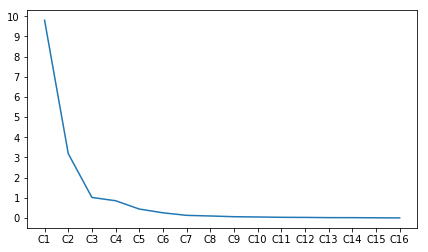

In [238]:
# Let's draw a Scree Plot using this information
# eig_pairs are now sorted in descending order. Let's fetch eigen_values from these pairs now.
eigen_values_sorted = [pair[0] for pair in eig_pairs]

# Let's plot No of components (on X-Axis) vs Eigen Value corresponding to each component as a line plot
plt.figure(figsize=(7, 4))
sns.lineplot(components, eigen_values_sorted, sort=False, sizes=(1, 10))
# Earlier on y-axis, it was showing values 2, 4, 6, 8, 10. But I wanted to see in more granular level, so I explicitly put
# in ytick values
plt.yticks(range(0, 11))
plt.show()

    Scree plot method helps to identify optimal no. of components from Scree Plot. There are two rules.
    1. Kaiser rule: Shortslists dimensions with Eigen Value > 1
    2. Elbow Plateau method: Shortlists dimensions that have a vertical drop in Eigen Value. Do not shortlist dimensions that form a horizontal plateau.

In [239]:
# According to these rules, C1 (Component-1), C2 (Component-2) and C3 (Component-3), really qualifies for being shortlisted.

In [240]:
# Now let's manually calculate the variance explained by these components. Remember, this project requires us to cover 
# more than 95% of variance. For this we need to go through sorted version of eigen values. We have eig_vals variable which can
# be used here.

total = sum(eigen_values_sorted)

variance_explained_by_each_component = [e_val/total for e_val in eigen_values_sorted]
np.array(variance_explained_by_each_component)

array([6.11815442e-01, 1.99042455e-01, 6.35247004e-02, 5.34372323e-02,
       2.76772783e-02, 1.60485739e-02, 8.16924565e-03, 6.25019259e-03,
       3.98807698e-03, 3.13021708e-03, 2.12096613e-03, 1.77874819e-03,
       1.12475761e-03, 1.05354828e-03, 5.93656965e-04, 2.44909193e-04])

In [241]:
# Let's check if manually calculated variance is same as returned by ready made API (PCA)
pcamodel.explained_variance_ratio_
# Cool both of them matches

array([6.11815442e-01, 1.99042455e-01, 6.35247004e-02, 5.34372323e-02,
       2.76772783e-02, 1.60485739e-02, 8.16924565e-03, 6.25019259e-03,
       3.98807698e-03, 3.13021708e-03, 2.12096613e-03, 1.77874819e-03,
       1.12475761e-03, 1.05354828e-03, 5.93656965e-04, 2.44909193e-04])

In [242]:
# Let's compute the cumulative variance explained by these components
cum_var_exp = np.cumsum(variance_explained_by_each_component)
cum_var_exp
# So it's evident that if we want to cover over 95% variance, then rather than 3 Components, we need go with 5 Components
# that helps us cover 95.549711 % variance.

array([0.61181544, 0.8108579 , 0.8743826 , 0.92781983, 0.95549711,
       0.97154568, 0.97971493, 0.98596512, 0.9899532 , 0.99308341,
       0.99520438, 0.99698313, 0.99810789, 0.99916143, 0.99975509,
       1.        ])

    Variance Summarized: Factor analysis employs the criterion of maximum reduction of variance - variance found in the initial set of variables. Each factor contributes to the reduction. The percentage of the initial variance associated with (or moved by) each factor is shown under the lablel "variance summarized"

In [243]:
# So let's draw the Variance Summarized table
var_summarized = pd.DataFrame(index=components, data={"Eigen Value" : eigen_values_sorted,
                                "% of Variance" : variance_explained_by_each_component,
                               "Cumulative %" : cum_var_exp})
var_summarized

Eigen Value  % of Variance  Cumulative %
C1      9.800632       0.611815      0.611815
C2      3.188448       0.199042      0.810858
C3      1.017598       0.063525      0.874383
C4      0.856008       0.053437      0.927820
C5      0.443361       0.027677      0.955497
C6      0.257081       0.016049      0.971546
C7      0.130863       0.008169      0.979715
C8      0.100121       0.006250      0.985965
C9      0.063885       0.003988      0.989953
C10     0.050143       0.003130      0.993083
C11     0.033976       0.002121      0.995204
C12     0.028494       0.001779      0.996983
C13     0.018017       0.001125      0.998108
C14     0.016877       0.001054      0.999161
C15     0.009510       0.000594      0.999755
C16     0.003923       0.000245      1.000000

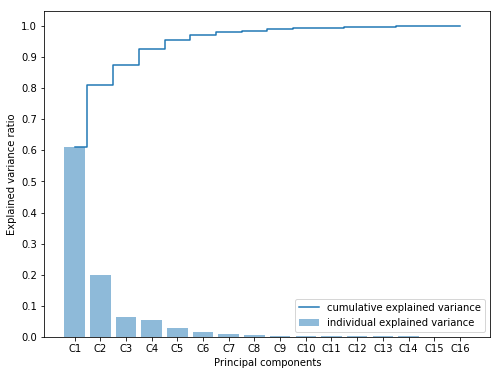

In [244]:
# There is an interesting plot of variance explained by each component and cumulative variance explained
# Clearly indicates that first two components explains slightly over 80% of variance.
plt.figure(figsize=(8, 6))
plt.bar(components, variance_explained_by_each_component, alpha=0.5, align='center', label='individual explained variance')
plt.step(components, cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [245]:
# Now we know that to cover over 95% of variance, we need to go with 5 components. Let's transform the original data to 
# these 5 components.
eigen_vectors_sorted = [pair[1] for pair in eig_pairs]
P_reduce = eigen_vectors_sorted[0:17]

Proj_data_2D = np.dot(X_Scaled, P_reduce)
Proj_data_2D[0:3]

array([[ 0.53872189, -1.13766397,  0.14279115, -0.16794005,  0.40278056,
         0.94219057,  0.31845084, -0.14247315,  0.23400447, -0.11199522,
         0.05739675,  0.48880894, -0.60102008,  1.01463315, -1.08369056,
         0.23455604],
       [ 0.37646971,  0.02540994, -1.24231903, -0.17340972, -0.09608659,
        -0.71889701, -0.19733055, -1.00558165, -0.26729826, -0.02492798,
        -0.27830848,  0.22411378, -0.33127841, -0.1799485 ,  0.68732892,
         0.4569785 ],
       [ 0.65910359, -0.07177426,  1.78500481,  0.98258296,  1.79720725,
         0.70053067, -0.25677871,  2.02749073,  0.36370097,  0.18332819,
         0.99284086,  0.37069315,  1.01647851,  1.01127808, -0.73398595,
        -0.91172102]])

In [246]:
data = pcamodel.transform(X)
data[0:3]

array([[-4.50953809e+02, -1.11414461e+02,  7.98970192e+01,
        -5.83555341e+01, -1.00637494e+02,  4.45323187e+01,
         1.58409244e+02,  3.18132216e+01, -3.67893760e+01,
         1.29189345e+02,  1.42293788e+02, -7.89625794e+01,
         1.20822105e+02,  1.11976888e+01,  2.40834050e+02,
        -1.22464734e+02],
       [-4.03037499e+02, -1.14992231e+02,  5.74127296e+01,
        -5.92281805e+01, -9.32101891e+01,  4.87161782e+01,
         1.65248603e+02,  3.71991029e+01, -1.93416957e+01,
         1.27922288e+02,  1.25161849e+02, -7.05100334e+01,
         1.20603666e+02,  4.20683801e-01,  2.12028282e+02,
        -9.71560738e+01],
       [-5.88978467e+02, -8.49969267e+01,  8.75089480e+01,
        -1.27607206e+02, -7.17452066e+01,  1.58128333e+01,
         1.71641963e+02,  7.26433221e+00, -8.48633536e+01,
         1.59895066e+02,  1.67657204e+02, -1.27212550e+02,
         1.57240284e+02, -2.40182542e+01,  3.70391360e+02,
        -2.64525960e+02]])